# Tweets Data Analysis
## Goal of Analysis: Use machine learning algorithms to classify the mood and tweet related topics 

In [63]:
#Imports needed for the project, if there will be any additional feature to download, we will provide links to sources where
#ones can download needed data

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import networkx as nx
import re
import math
import random
import pyLDAvis
import pyLDAvis.gensim
import gensim
import spacy
import nltk

from spacy import load
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud
from matplotlib.colors import LinearSegmentedColormap
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from scipy import stats

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.tag import pos_tag
from scipy.stats import mannwhitneyu, mood, ks_2samp, pearsonr, pointbiserialr
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

from textblob import TextBlob
from nrclex import NRCLex
from collections import Counter
from afinn import Afinn

## Preprocessing section 

### Reading data and set settings for Jupyter Notebook

- jupyter-settings may be visible- adding just in case

In [3]:
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

- preparing-access, reading tweets data with right encoding

In [4]:
#reading data latin1 encoding
tweets = pd.read_csv("assets/tweets.csv", encoding="latin1")

### First insights and data cleaning

- insights- what kind of columns do we have

In [5]:
#types of data in column, needed later for substitute
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Target  1048575 non-null  int64 
 1   ID      1048575 non-null  int64 
 2   Date    1048575 non-null  object
 3   flag    1048575 non-null  object
 4   User    1048575 non-null  object
 5   Text    1048575 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB


In [6]:
#before building our model we must understand what are our desires and what columns are needed
tweets.columns

Index(['Target', 'ID', 'Date', 'flag', 'User', 'Text'], dtype='object')

In [8]:
#showing few results
tweets.head()

,Target,ID,Date,flag,User,Text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


now we will get rid of some not used columns <br>
first of all the **User** columns seems redundant, as the User nickname seems not representative eneugh to judge by it the Target <br>
the same thing may be told about **ID**

In [9]:
tweets['flag'].unique()

array(['NO_QUERY'], dtype=object)

as there is no unique flag it seems rather fair to not include also **flag** column

In [10]:
tweets_df= tweets.drop(['ID', 'flag', 'User'], axis=1)

In [11]:
tweets_df.head()

,Target,Date,Text
0,0,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...
1,0,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...
2,0,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire
3,0,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all...."
4,0,Mon Apr 06 22:20:00 PDT 2009,@Kwesidei not the whole crew


In [12]:
#we will have to make small change
tweets_df['Target'].unique()

array([0, 4], dtype=int64)

the values 0 and 4 seems not intuitive, beacuse we only have does values, we will asume that 0 means negative statiment and 1(previosly 4)will mean positive statiment

In [13]:
tweets_df['Target'].replace([4], 1, inplace=True)

- section of data seperation for two teams one will go for validation team. This data frame we will not touch

In [15]:
#splitting data for development and validation team
dev_df, val_df = train_test_split(tweets_df, test_size=0.3, random_state=42)
dev_train_df, dev_val_df = train_test_split(dev_df, test_size=0.3, random_state=42)

tweets_df= dev_train_df
team_validation= val_df

- data cleaning and in it preprocessing

1. removing special chars and punctuation marks
2. text tokenization
3. text normalization
4. deleting meaningless words
5. lemmatization

In [16]:
#1. removing special chars and punctutation marks
# if char not in ABC... and not in abc... and is not ' ','' or "'"(apostrophe for can't, it's etc), then substitute with ' '

allowed_characters = set(chr(i) for i in range(256) if chr(i).isalpha())

def filter_characters(text):
    considering_text=''
    for character in text:
        if character in allowed_characters or character==' ' or character=='' or character=="'":
            considering_text+=character
        else:
            considering_text+=' '
    return considering_text

def extra_spaces_remover(text):
    text_to_change = re.sub(r'\s+', ' ', text)
    changed_text = text_to_change.strip()
    return changed_text

#removing additionals ' ', if there are more then 1 ' ' chars next to each other substitute it with single ' '

tweets_df['Text']= tweets_df['Text'].apply(filter_characters, extra_spaces_remover)
dev_val_df['Text']= dev_val_df['Text'].apply(filter_characters, extra_spaces_remover)
team_validation['Text']= team_validation['Text'].apply(filter_characters, extra_spaces_remover)

tweets_df.head()

,Target,Date,Text
2316,0,Tue Apr 07 01:08:23 PDT 2009,A day negotiating wth insurers after spilling ...
29697,0,Sun Apr 19 23:17:52 PDT 2009,mindyyeung whats wrong
797003,0,Thu Jun 25 09:02:20 PDT 2009,hey you twitterers out there which mac virus ...
409607,0,Sat Jun 06 17:25:30 PDT 2009,I'm stressed about this A'level
175753,0,Fri May 29 15:07:14 PDT 2009,damn sunburn hurting jack whitehall mmmmm


In [17]:
#2. text tokenization
#simply by using `split` method

def eng_tokenization(text):
    return text.split()

tweets_df['tokens']= tweets_df['Text'].apply(eng_tokenization)
dev_val_df['tokens']= dev_val_df['Text'].apply(eng_tokenization)
team_validation['tokens']= team_validation['Text'].apply(eng_tokenization)

tweets_df.head()

,Target,Date,Text,tokens
2316,0,Tue Apr 07 01:08:23 PDT 2009,A day negotiating wth insurers after spilling ...,"[A, day, negotiating, wth, insurers, after, sp..."
29697,0,Sun Apr 19 23:17:52 PDT 2009,mindyyeung whats wrong,"[mindyyeung, whats, wrong]"
797003,0,Thu Jun 25 09:02:20 PDT 2009,hey you twitterers out there which mac virus ...,"[hey, you, twitterers, out, there, which, mac,..."
409607,0,Sat Jun 06 17:25:30 PDT 2009,I'm stressed about this A'level,"[I'm, stressed, about, this, A'level]"
175753,0,Fri May 29 15:07:14 PDT 2009,damn sunburn hurting jack whitehall mmmmm,"[damn, sunburn, hurting, jack, whitehall, mmmmm]"


In [18]:
#3. text normalization
#simply by forcing letters to be in lowercase format

def eng_normalization(arr):
    tokens=[]
    for word in arr:
        tokens.append(word.lower())
    return tokens

tweets_df['tokens']= tweets_df['tokens'].apply(eng_normalization)
dev_val_df['tokens']= dev_val_df['tokens'].apply(eng_normalization)
team_validation['tokens']= team_validation['tokens'].apply(eng_normalization)

In [19]:
#4. deleting meaningless words
#we want to delete stop words, such as: "and", "in", "also" etc
#we are using here NLTK(Natural Language Toolkit) library from which we gain access of stop words

#one's may need to download these list of stop words
#nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

tweets_df['tokens']= tweets_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
dev_val_df['tokens']= dev_val_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
team_validation['tokens']= team_validation['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

tweets_df.head()

,Target,Date,Text,tokens
2316,0,Tue Apr 07 01:08:23 PDT 2009,A day negotiating wth insurers after spilling ...,"[day, negotiating, wth, insurers, spilling, be..."
29697,0,Sun Apr 19 23:17:52 PDT 2009,mindyyeung whats wrong,"[mindyyeung, whats, wrong]"
797003,0,Thu Jun 25 09:02:20 PDT 2009,hey you twitterers out there which mac virus ...,"[hey, twitterers, mac, virus, protection, soft..."
409607,0,Sat Jun 06 17:25:30 PDT 2009,I'm stressed about this A'level,"[i'm, stressed, a'level]"
175753,0,Fri May 29 15:07:14 PDT 2009,damn sunburn hurting jack whitehall mmmmm,"[damn, sunburn, hurting, jack, whitehall, mmmmm]"


In [20]:
#5. lemmatization(break a word down to its root meaning to identify similarities) Examples: "better"->"good", "walking"->"walk"
#before making lemmatization we have to know which part of speech the word is: verb, noun, adjective, adverb

#one's may need to download these list of data
#nltk.download('averaged_perceptron_tagger')

def part_of_speech_classifier(tokens):
    return pos_tag(tokens)

tweets_df['tags']= tweets_df['tokens'].apply(part_of_speech_classifier)
dev_val_df['tags']= dev_val_df['tokens'].apply(part_of_speech_classifier)
team_validation['tags']= team_validation['tokens'].apply(part_of_speech_classifier)

tweets_df.head()

,Target,Date,Text,tokens,tags
2316,0,Tue Apr 07 01:08:23 PDT 2009,A day negotiating wth insurers after spilling ...,"[day, negotiating, wth, insurers, spilling, be...","[(day, NN), (negotiating, VBG), (wth, NN), (in..."
29697,0,Sun Apr 19 23:17:52 PDT 2009,mindyyeung whats wrong,"[mindyyeung, whats, wrong]","[(mindyyeung, NN), (whats, NNS), (wrong, VBP)]"
797003,0,Thu Jun 25 09:02:20 PDT 2009,hey you twitterers out there which mac virus ...,"[hey, twitterers, mac, virus, protection, soft...","[(hey, NN), (twitterers, NNS), (mac, VBP), (vi..."
409607,0,Sat Jun 06 17:25:30 PDT 2009,I'm stressed about this A'level,"[i'm, stressed, a'level]","[(i'm, NN), (stressed, VBD), (a'level, NN)]"
175753,0,Fri May 29 15:07:14 PDT 2009,damn sunburn hurting jack whitehall mmmmm,"[damn, sunburn, hurting, jack, whitehall, mmmmm]","[(damn, NN), (sunburn, NN), (hurting, VBG), (j..."


In [21]:
#now we may lemmatize using method from nltk package
#additional info: we could not determinate part of speech and just lemmatize, and then setting specific lemma for each word(the first found lemma), but that approach
#is worse then the one with using `tags` information, beacuse now we can find exact lemma for each word(not the first found one, but the exact one)

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tags):
    lemmatized_tokens = []
    for tok, tag in tags:
        if tag.startswith('N'):
            lemmatized_tokens.append(lemmatizer.lemmatize(tok, pos='n'))
        elif tag.startswith('V'):
            lemmatized_tokens.append(lemmatizer.lemmatize(tok, pos='v'))
        elif tag.startswith('J'):
            lemmatized_tokens.append(lemmatizer.lemmatize(tok, pos='a'))
        elif tag.startswith('R'):
            lemmatized_tokens.append(lemmatizer.lemmatize(tok, pos='r'))
        else:
            lemmatized_tokens.append(tok) #in case if different type of speech
    return lemmatized_tokens

tweets_df['lemmatized_tokens'] = tweets_df['tags'].apply(lemmatize_tokens)
dev_val_df['lemmatized_tokens'] = dev_val_df['tags'].apply(lemmatize_tokens)
team_validation['lemmatized_tokens'] = team_validation['tags'].apply(lemmatize_tokens)

tweets_df.head()

,Target,Date,Text,tokens,tags,lemmatized_tokens
2316,0,Tue Apr 07 01:08:23 PDT 2009,A day negotiating wth insurers after spilling ...,"[day, negotiating, wth, insurers, spilling, be...","[(day, NN), (negotiating, VBG), (wth, NN), (in...","[day, negotiate, wth, insurer, spill, beer, la..."
29697,0,Sun Apr 19 23:17:52 PDT 2009,mindyyeung whats wrong,"[mindyyeung, whats, wrong]","[(mindyyeung, NN), (whats, NNS), (wrong, VBP)]","[mindyyeung, whats, wrong]"
797003,0,Thu Jun 25 09:02:20 PDT 2009,hey you twitterers out there which mac virus ...,"[hey, twitterers, mac, virus, protection, soft...","[(hey, NN), (twitterers, NNS), (mac, VBP), (vi...","[hey, twitterer, mac, virus, protection, softw..."
409607,0,Sat Jun 06 17:25:30 PDT 2009,I'm stressed about this A'level,"[i'm, stressed, a'level]","[(i'm, NN), (stressed, VBD), (a'level, NN)]","[i'm, stress, a'level]"
175753,0,Fri May 29 15:07:14 PDT 2009,damn sunburn hurting jack whitehall mmmmm,"[damn, sunburn, hurting, jack, whitehall, mmmmm]","[(damn, NN), (sunburn, NN), (hurting, VBG), (j...","[damn, sunburn, hurt, jack, whitehall, mmmmm]"


## Data analysis and trends finding 

### Sentiment distribution analysis


- Sentiment distribution

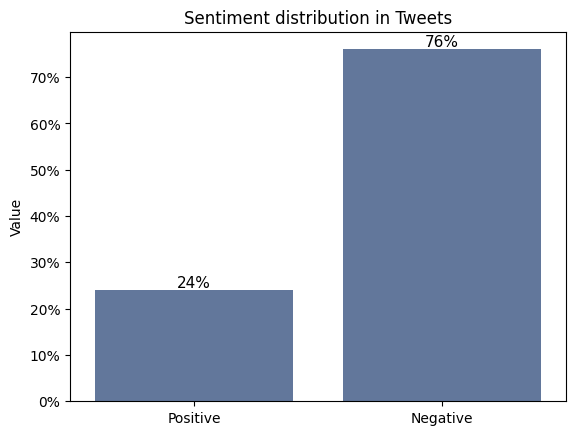

In [22]:
#the first step is to understand whether tweets tend to be positive or negative in general, that will help us
#determinate the mood on this social media platform for majory of people


positive_attitudes=tweets_df['Target'][tweets_df['Target']==1].count()
negative_attitudes=tweets_df['Target'][tweets_df['Target']==0].count()

all_records= tweets_df.shape[0]

sentiment_distribution= {'Target': ['Positive', 'Negative'], 'Value': 
                         [round(positive_attitudes/all_records, 2)*100, round(negative_attitudes/all_records, 2)*100]}

sentiment_distribution_df= pd.DataFrame(sentiment_distribution)

ax= sns.barplot(data= sentiment_distribution_df, x= "Target", y="Value", color="#5975A4")

ax.set(title="Sentiment distribution in Tweets")

def percent(x, pos):
    return '%1.0f%%' % x

ax.yaxis.set_major_formatter(ticker.FuncFormatter(percent))

ax.set_xlabel("")

for p in ax.patches:
    value = str(p.get_height()).rstrip('0').rstrip('.')
    ax.annotate(f'{value}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### Length of statements analysis


- Length distribution correlated with attidute

1. determining the length of lemmatized tokens
2. study of the average length of utterances
3. visualization of group distributions lengths of lemmatized tokens
4. statistical tests(Mann–Whitney U test, Mood test)
5. correlation analysis

In [23]:
#the first step is to determinate whether in specific group the number of words per sentiment differ
tweets_df['words_counted']= tweets_df['lemmatized_tokens'].apply(lambda x: len(x))
dev_val_df['words_counted']= dev_val_df['lemmatized_tokens'].apply(lambda x: len(x))
team_validation['words_counted']= team_validation['lemmatized_tokens'].apply(lambda x: len(x))

avg_words_statement=tweets_df.groupby(['Target']).apply(lambda x: round(x['words_counted'].sum()/len(x), 3))

avg_words_statement

Target
0    7.936
1    7.970
dtype: float64

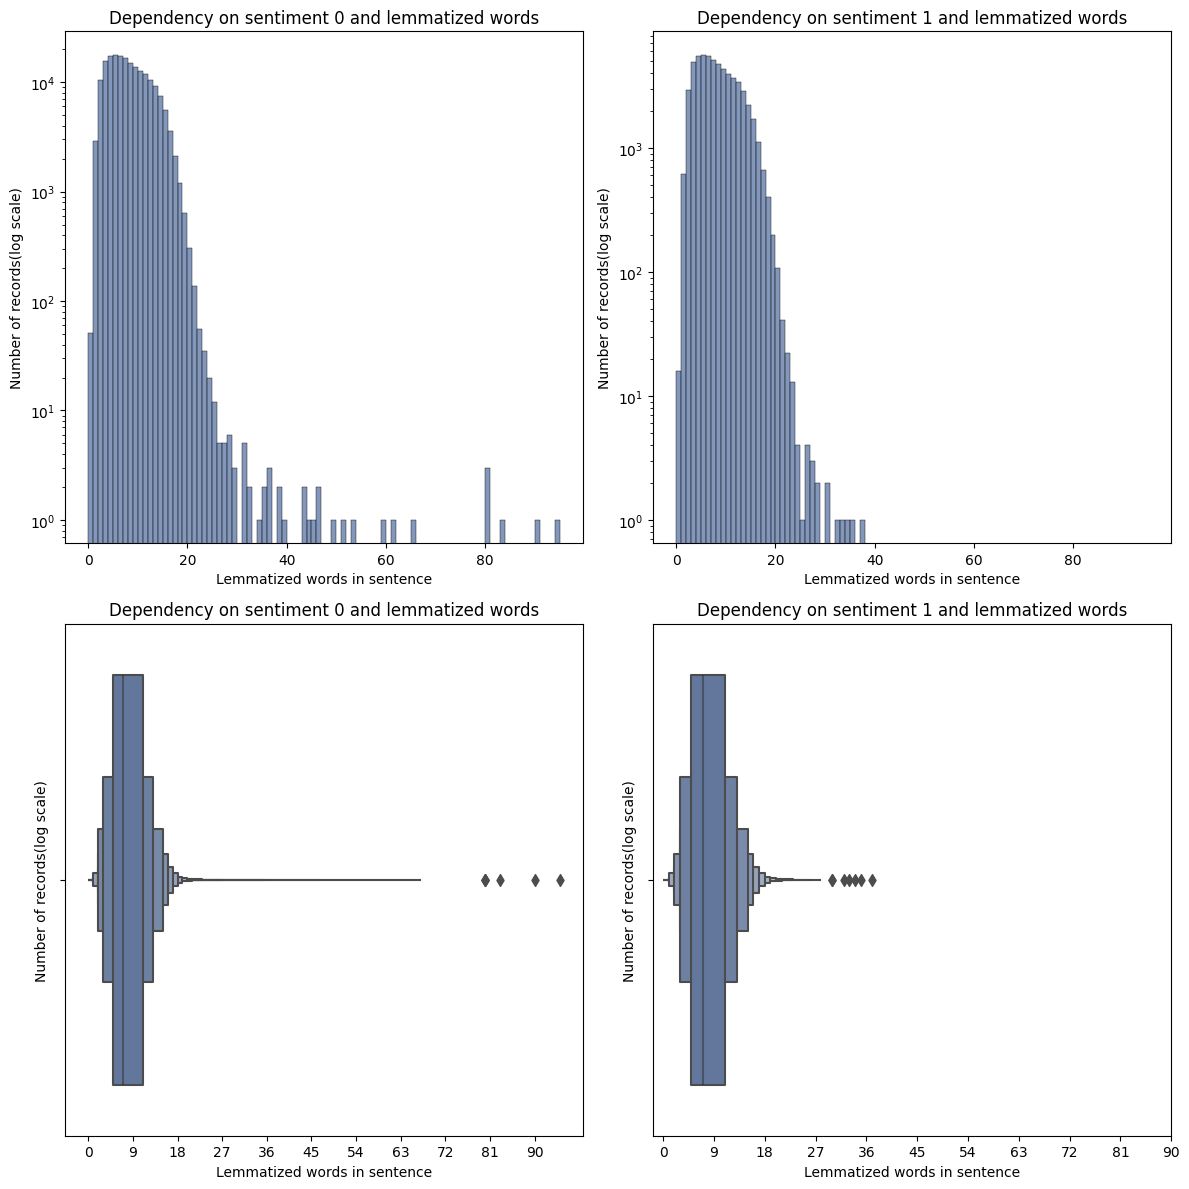

In [26]:
negative_df = tweets_df[tweets_df['Target'] == 0]
positive_df = tweets_df[tweets_df['Target'] == 1]

negative_df_val= dev_val_df[dev_val_df['Target'] == 0]
positive_df_val= dev_val_df[dev_val_df['Target'] == 1]

color = '#5975A4'

# setting range on x axes
bins_range = (0, max(max(negative_df['words_counted']), max(positive_df['words_counted'])))

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# # histogram for bad sentiment
sns.histplot(negative_df['words_counted'], ax=axes[0, 0], color=color, bins=bins_range[1], binrange=bins_range)
axes[0, 0].set_title('Dependency on sentiment 0 and lemmatized words')
axes[0, 0].set_xlabel('Lemmatized words in sentence')
axes[0, 0].set_ylabel('Number of records(log scale)')
axes[0, 0].set_yscale('log')  # logarithm of corresponding values

# # histogram for good sentiment
sns.histplot(positive_df['words_counted'], ax=axes[0, 1], color=color, bins=bins_range[1], binrange=bins_range)
axes[0, 1].set_title('Dependency on sentiment 1 and lemmatized words')
axes[0, 1].set_xlabel('Lemmatized words in sentence')
axes[0, 1].set_ylabel('Number of records(log scale)')
axes[0, 1].set_yscale('log')  # logarithm of corresponding values

# # boxenplot for bad sentiment
sns.boxenplot(x=negative_df['words_counted'], ax=axes[1, 0], color=color, width=0.8)
axes[1, 0].set_title('Dependency on sentiment 0 and lemmatized words')
axes[1, 0].set_xlabel('Lemmatized words in sentence')
axes[1, 0].set_ylabel('Number of records(log scale)')
axes[1, 0].set_xticks(range(0, bins_range[1], bins_range[1] // 10))  # setting appearing values on x axes

# # histogram for good sentiment
sns.boxenplot(x=positive_df['words_counted'], ax=axes[1, 1], color=color, width=0.8)
axes[1, 1].set_title('Dependency on sentiment 1 and lemmatized words')
axes[1, 1].set_xlabel('Lemmatized words in sentence')
axes[1, 1].set_ylabel('Number of records(log scale)')
axes[1, 1].set_xticks(range(0, bins_range[1], bins_range[1] // 10))  # setting appearing values on x axes

plt.tight_layout()
plt.show()

In [28]:
#statistical tests, will help us determinate, wheter difference in records in groups is due to accident
#or real difference among records

#we can't use t-Student's test due to the fact that distribution of sentiments is not a normal distribution(to use t-Student's test
#we have to make sure that values are from normal distribution)
#that's why we will use Mann-Whitney U test

negative_statiment = tweets_df[tweets_df['Target'] == 0]['words_counted']
positive_statiment = tweets_df[tweets_df['Target'] == 1]['words_counted']

negative_statiment_val = dev_val_df[dev_val_df['Target'] == 0]['words_counted']
positive_statiment_val = dev_val_df[dev_val_df['Target'] == 1]['words_counted']

statistics, p_value= mannwhitneyu(negative_statiment, positive_statiment)

mann_whitney_result= {"statistics": statistics, "p_value": p_value}
mann_whitney_df = pd.DataFrame(mann_whitney_result, index=['Mann-Whitney Result'])

mann_whitney_df

,statistics,p_value
Mann-Whitney Result,5.699244e+09,0.038425


In [29]:
#due to value p= 0.000001 we may interpret it as there are 
#statistically significant differences between the groups in the context of the length of the statement
#in our interpretation we used the convention that if p< 0.05 then we reject the null hypothesis and there must be some differences among records
#and the groups they belong to

#To make sure of our beliefs, we will also use the mood test
statistic, p_value = mood(negative_statiment, positive_statiment)

moods_result= {"statistics": statistics, "p_value": p_value}
moods_df = pd.DataFrame(moods_result, index=['Moods Result'])

#In the Mood test the p_value will determinate the probability that the same result will be given if we have the same distribution
#the very low value tells us that we have different distributions
moods_df

,statistics,p_value
Moods Result,5.699244e+09,7.353376e-07


In [30]:
#correlation analysis between statiment and amount of words

correlation, p= pearsonr(tweets_df['words_counted'], tweets_df['Target'])
correlation_df= pd.DataFrame({"Correlation":correlation}, index= ["Correlation result"])

correlation_df

,Correlation
Correlation result,0.003542


In [20]:
#conclusions drawn from statistical tests and correlation analysis:
#there is a non-accidental difference between groups of statistics, but there is no simple relationship that can be determined using correlation

### Frequency of words analysis

1. finding most positive and negative words used in each statiment with results shown
2. comparision of most frequent positive words and their equivalent, the same for negative and equivalents
3. table analysis of percentege of data for words appearing more often in negative statiment and demonstration of possible reason
4. emotion prediction for words appearing in scalars(check third point)
5. collocation analysis for bigrams(graph representations and differences with words embedding)

- most frquently used positive and negative words visualization

In [32]:
#first let's make a useful dictonaries containing words counters for each statiment

from collections import Counter

positive_words= []
negative_words= [] 

for words in tweets_df[tweets_df['Target']==1]['lemmatized_tokens']:
    positive_words.extend(words)
for words in tweets_df[tweets_df['Target']==0]['lemmatized_tokens']:
    negative_words.extend(words)

positive_words_frequency= Counter(positive_words)
negative_words_frequency= Counter(negative_words)

df_positive_words= pd.DataFrame.from_dict(positive_words_frequency, orient="index").reset_index()
df_negative_words= pd.DataFrame.from_dict(negative_words_frequency, orient="index").reset_index()

df_positive_words.rename(columns={"index":"positive_word", 0:"amount"}, inplace=True)
df_negative_words.rename(columns={"index":"negative_word", 0:"amount"},inplace=True)

df_positive_words.sort_values(by= "amount", ascending=False, inplace=True)
df_negative_words.sort_values(by= "amount", ascending=False, inplace=True)

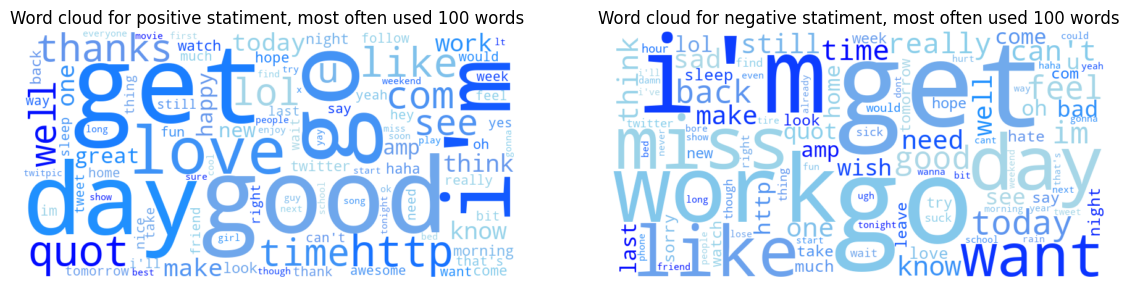

In [35]:
#now basic visualization to see if there are words which are more often used in spacific statiment but only 100 most popular

colors = ['#ADD8E6', '#87CEEB', '#6495ED', '#1E90FF', '#0000FF']
blue_gradient_map = LinearSegmentedColormap.from_list('blue_gradient', colors)

positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=blue_gradient_map) \
                        .generate_from_frequencies(dict(df_positive_words[:100].values))

negative_wordcloud= WordCloud(width=800, height=400, background_color='white', colormap=blue_gradient_map) \
                    .generate_from_frequencies(dict(df_negative_words[:100].values))

plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)

plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word cloud for positive statiment, most often used 100 words')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word cloud for negative statiment, most often used 100 words')
plt.axis('off')

plt.show()

- comparision of most frequent positive words and their equivalent(the same goes for negatives)

C:\Users\igorr\AppData\Local\Temp\ipykernel_45360\2065457221.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positve_words['source'] = 'positive'
C:\Users\igorr\AppData\Local\Temp\ipykernel_45360\2065457221.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_words2['source']= 'negative'


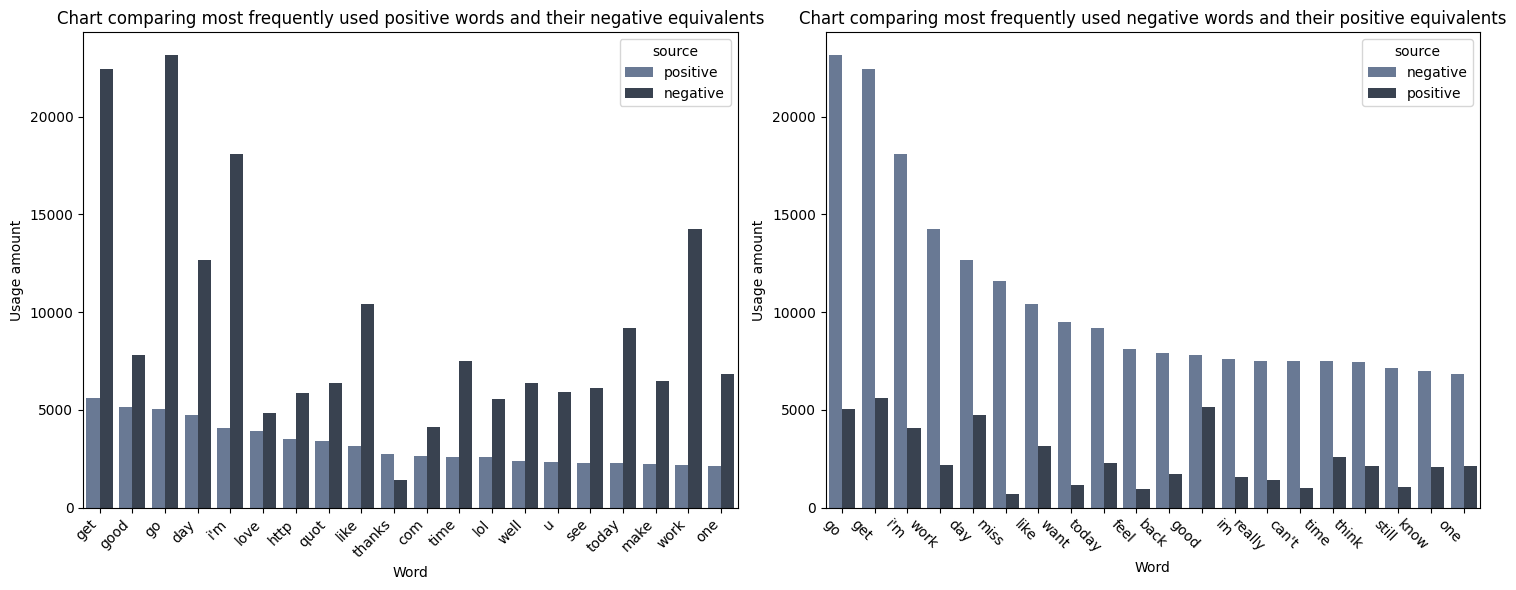

In [36]:
#it's better to compare 20 most often used words for each statiment in more visible way(not 100 beacuse it is not very esthetical)

most_positive_words_set= df_positive_words[:20]['positive_word']
most_negative_words_set= df_negative_words[:20]['negative_word']

contrast_to_positive_words= df_negative_words[df_negative_words['negative_word'].isin(most_positive_words_set)]
contrast_to_negative_words= df_positive_words[df_positive_words['positive_word'].isin(most_negative_words_set)]

negative_words= pd.DataFrame({"positive_word": contrast_to_positive_words['negative_word'], "amount": contrast_to_positive_words['amount']})
positve_words= df_positive_words[:20]

positive_words2= pd.DataFrame({"negative_word": contrast_to_negative_words['positive_word'], 'amount': contrast_to_negative_words['amount']})
negative_words2= df_negative_words[:20]

positve_words['source'] = 'positive'
negative_words['source'] = 'negative'

negative_words2['source']= 'negative'
positive_words2['source']= 'positive'

merged_data = pd.concat([positve_words, negative_words])
merged_data2= pd.concat([negative_words2, positive_words2])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(ax= axes[0], x='positive_word', y='amount', hue='source', data=merged_data, palette={'positive': '#62779B', 'negative': '#354154'})

axes[0].set_xlabel('Word')
axes[0].set_ylabel('Usage amount')
axes[0].set_title('Chart comparing most frequently used positive words and their negative equivalents')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

sns.barplot(ax= axes[1], data=merged_data2, x="negative_word", y='amount', hue='source', palette={'negative': '#62779B', 'positive': '#354154'})

axes[1].set_xlabel('Word')
axes[1].set_ylabel('Usage amount')
axes[1].set_title('Chart comparing most frequently used negative words and their positive equivalents')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=315, ha='right')


plt.tight_layout()
plt.show()

- dividing words into their greater popularity in a negative use case and thier's probabilistic selection of groups

In [37]:
#the possible insight of right plot can be made much easier then the left one. 
#Quick question arising: how many percentege of words tend to look like right plot(words used more than twice as often in a given statiment)

pos_neg_df = pd.merge(df_negative_words, df_positive_words, left_on='negative_word', right_on='positive_word', how='left')

pos_neg_df.rename({'negative_word': "word"}, inplace=True)
pos_neg_df.drop('positive_word', axis=1, inplace=True)
pos_neg_df['indicator']= pos_neg_df['amount_x']/pos_neg_df['amount_y']
pos_neg_df.drop(['amount_x', 'amount_y'], axis=1, inplace=True)

#considering only non NaN records
pos_neg_df= pos_neg_df[pos_neg_df['indicator'].notna()]

rows=pos_neg_df.shape[0]

summary_df = pd.DataFrame()
for i in range(1, 21):  # Przykładowo od 1 do 10
    count = pos_neg_df[pos_neg_df['indicator'] > i].shape[0]
    summary_df = pd.concat([summary_df, pd.DataFrame({'indicator_value': [i], 'count': [count]})], ignore_index=True)

summary_df['count']= summary_df['count'].apply(lambda x: x/rows*100)

summary_df
#we thus determine the probability from the uniform distribution of data that a 
#randomly selected word will appear (more than) indicator_value times more often in sentiment 0 than in sentiment 1

#for example: there is around 36.643908 percentage chance that a random word will appear more then twice time often in sentiment 0 sentence then in sentiment 1 sentence

,indicator_value,count
0,1,62.057256
1,2,40.546265
2,3,25.702914
3,4,17.019645
4,5,11.765135
5,6,8.416709
6,7,6.426641
7,8,5.075586
8,9,3.947272
9,10,3.224275


- negative words group interpretation 

In [86]:
specific_neg = {20: [], 19: [], 18: [], 17: [], 16: [], 15: [], 14: [], 13: [], 12: [], 11: [], 10: []}

def specific_words_appender(record):
    val = math.floor(record['indicator'])
    if val >= 10:
        if val >= 20:
            valSpec = 20
        else:
            valSpec = val
        en_set = specific_neg[valSpec]
        en_set.append(record['negative_word'])
        specific_neg[valSpec] = en_set

for index, row in pos_neg_df.iterrows():
    specific_words_appender(row)

specific_neg_df = pd.DataFrame(list(specific_neg.items()), columns=['scalar', 'negative_words'])

specific_neg_df

specific_neg_df.to_csv('specific_neg_df.csv', index=False)

In [39]:
#the first glance allows us to intuitively understand what all these words in statiment 0 have in common. First of all, they touch on emotional topics
#The bigger the scalar is the more negative associations the given words have, to the point that the have only negative meaning

- emotion analysis for negative words groups

In [40]:
#We gained package from https://github.com/cjhutto/vaderSentiment?tab=readme-ov-file#introduction
#below we put some comments about interpretation of below statistics

words_analyse= SentimentIntensityAnalyzer()

negative_percentage_list=[]
neutral_percentage_list=[]
positive_percentage_list=[]

def emotions_finder(record):
    words= record['negative_words']
    
    positive_words= 0
    neutral_words= 0
    negative_words= 0
    
    for word in words:
        sen_score= words_analyse.polarity_scores(word)

        if sen_score['compound'] >=0.05:
            positive_words+=1
        elif -0.05<sen_score['compound']<0.05:
            neutral_words+=1
        else:
            negative_words+=1
    
    positive_percentage_list.append(positive_words/len(words))
    neutral_percentage_list.append(neutral_words/len(words))
    negative_percentage_list.append(negative_words/len(words))

for index, row in specific_neg_df.iterrows():
    emotions_finder(row)

positive_percentage_list= [round(record, 6) for record in positive_percentage_list]
neutral_percentage_list= [round(record, 6) for record in neutral_percentage_list]
negative_percentage_list= [round(record, 6) for record in negative_percentage_list]

specific_neg_df['percentage_negative_by_100']= negative_percentage_list
specific_neg_df['percentage_positive_by_100']= positive_percentage_list
specific_neg_df['percentage_neutral_by_100']= neutral_percentage_list

specific_neg_df

,scalar,negative_words,percentage_negative_by_100,percentage_positive_by_100,percentage_neutral_by_100
0,20,"[sad, hate, sick, suck, hurt, ugh, poor, cry, ...",0.331839,0.008969,0.659193
1,19,"[dentist, dammit, nightmare, noooo, funeral, b...",0.133333,0.033333,0.833333
2,18,"[allergy, grrr, where's, worried, bueno, ughhh...",0.137931,0.000000,0.862069
3,17,"[battery, afford, accident, miserable, mitchel...",0.147059,0.000000,0.852941
4,16,"[miss, anymore, crap, scar, goodbye, yuck, bah...",0.134615,0.000000,0.865385
5,15,"[stupid, fail, pain, wont, boring, ruin, sims,...",0.224138,0.017241,0.758621
6,14,"[die, wtf, stuck, nose, crappy, loss, suddenly...",0.174603,0.015873,0.809524
7,13,"[bad, lose, boo, sigh, father, expensive, neck...",0.162791,0.011628,0.825581
8,12,"[sorry, damn, alone, fell, tear, bloody, cough...",0.135922,0.000000,0.864078
9,11,"[bore, cold, hungry, doesnt, hospital, dang, k...",0.179856,0.028777,0.791367


For example the scalar=20, means that values appearing in column **negative_words** are appearing 20 times more often in negative statiment then in positive_statiment<br>,
columns **percentage_negative_by_100** means what percentage from words appearing for **negative_words** are negative ones, for **percentage_positive_by_100** means percentage of values<br>
appearing in column **negative_words** which are classified as postive, and **percentage_neutral_by_100** percentage for neutral ones<br>
We can add to our observations the fact that usually words classified as statiment 0 do not contain positive words if the scalar is large enough

- Collocation analysis(bigrams) with the usage of graphs and words embodding

In [42]:
#Collocation analysis, i.e. analysis of neighboring words
#approach to the problem: we will use statistical method pointwise mutual information PMI to find some collocations between words, the high PMI value will determine collocation

#dividing to n-grams, n-grams are basically bunch of words which appear next to each other in the sentence and we consider those words as one "whole" and check some statistics for them
#for example, if we consider words: "This is my friend", then interpreting 2-grams, we get: (This, is), (is, my), (my, friend)

collocations_list=[]

collocations_list1=[]

collocations_list2=[]

def define_collocations(tokens):
    bigrams= list(ngrams(tokens, 2))
    collocations_list.append(bigrams)


def define_collocations1(tokens):
    bigrams= list(ngrams(tokens, 2))
    collocations_list1.append(bigrams)

def define_collocations2(tokens):
    bigrams= list(ngrams(tokens, 2))
    collocations_list2.append(bigrams)

tweets_df['lemmatized_tokens'].apply(define_collocations)
dev_val_df['lemmatized_tokens'].apply(define_collocations1)
team_validation['lemmatized_tokens'].apply(define_collocations2)

tweets_df['collocations']= collocations_list
dev_val_df['collocations']= collocations_list1
team_validation['collocations']= collocations_list2

negative_collocations=tweets_df[tweets_df['Target']==0]['collocations']
positive_collocations=tweets_df[tweets_df['Target']==1]['collocations']

positive_collocations.reset_index(drop=True, inplace=True)

In [44]:
#finding the most popular bigrams for negative statiment and positive statiment
collocations_list_dict=[{}, {}]

def collocations_counter(records, indicator):
    
    for i in range(len(records)):
        data= records[i]
        for j in range(len(data)):
            tup= data[j]
            if collocations_list_dict[indicator].get(tup) == None:
                collocations_list_dict[indicator][tup]= 1
            else:
                collocations_list_dict[indicator][tup]+= 1

negative_collocations.reset_index(drop=True, inplace=True)               
positive_collocations.reset_index(drop=True, inplace=True)

collocations_counter(negative_collocations, 0)
collocations_counter(positive_collocations, 1)

negative_collocations_dict= pd.DataFrame.from_dict(collocations_list_dict[0], orient='index')
postivive_collocations_dict= pd.DataFrame.from_dict(collocations_list_dict[1], orient='index')

negative_collocations_dict.rename(columns={0:"amount"},inplace=True)
postivive_collocations_dict.rename(columns={0:"amount"},inplace=True)

negative_collocations_dict.sort_values(by='amount', ascending=False,inplace=True)
postivive_collocations_dict.sort_values(by='amount', ascending=False,inplace=True)

In [46]:
negative_collocations_dict.head()

,amount
"(last, night)",1845
"(feel, like)",1715
"(twitpic, com)",1501
"(http, twitpic)",1486
"(wish, could)",1468


In [47]:
negative_collocations_dict.head()

,amount
"(last, night)",1845
"(feel, like)",1715
"(twitpic, com)",1501
"(http, twitpic)",1486
"(wish, could)",1468


In [48]:
small_sample= postivive_collocations_dict.index.to_list()
small_sample2= negative_collocations_dict.index.to_list()

#first semantic analysis, we are modelling here the statiment_score and the probability that within
#those collocations if sentiment_score>=x then we conclude that value has given_sentiment, then we check what is a percentage of results that have given_statiment
#For example, sentiment_score = 0.1 means that only those samples that have a sentiment score greater than or equal to 0.1 are considered positive, and all others are considered negative.

analyzer = SentimentIntensityAnalyzer()
sentiment_scores= []
sentiment_scores2= []

for bigram in small_sample:
    bigram_str = ' '.join(bigram)
    sentiment_scores.append(analyzer.polarity_scores(bigram_str)['pos'])

for bigram in small_sample2:
    bigram_str = ' '.join(bigram)
    sentiment_scores2.append(analyzer.polarity_scores(bigram_str)['neg'])


small_sample_df= pd.DataFrame({'bigram': small_sample, "sentiment_predicator":sentiment_scores })
small_sample2_df= pd.DataFrame({'bigram': small_sample2, "sentiment_predicator":sentiment_scores2 })

values = [round(i * 0.1, 1) for i in range(1, 10)]
probability = [len(small_sample_df[small_sample_df['sentiment_predicator'] >= value])/len(small_sample) for value in values]

probability2=   [len(small_sample2_df[small_sample2_df['sentiment_predicator'] >= value])/len(small_sample2) for value in values]


semantic_results = pd.DataFrame({'sentiment_score': values, 'Probability': probability})
semantic_results2=  pd.DataFrame({'sentiment_score': values, 'Probability': probability2})

In [49]:
#here goes statistics for positive_collocations:
semantic_results

,sentiment_score,Probability
0,0.1,0.252853
1,0.2,0.252853
2,0.3,0.252746
3,0.4,0.251965
4,0.5,0.249584
5,0.6,0.239768
6,0.7,0.198375
7,0.8,0.039762
8,0.9,0.016722


In [50]:
#here goes statistics for negative_collocations:
semantic_results2

,sentiment_score,Probability
0,0.1,0.155472
1,0.2,0.155472
2,0.3,0.155034
3,0.4,0.153419
4,0.5,0.149856
5,0.6,0.131971
6,0.7,0.100052
7,0.8,0.012039
8,0.9,0.006921


In [53]:
#second syntatic analysis and frequency of sentence parts

#considering only those recrods which sentime_score positivitiy is >=0.5
small_sample_df_half_positive= small_sample_df[small_sample_df['sentiment_predicator']>=0.5]
small_sample_df_half_negative= small_sample2_df[small_sample2_df['sentiment_predicator']>=0.5]

pos_combinations = []
neg_combinations = []

# deciding the type of sentence
for bigram in small_sample_df_half_positive['bigram']:
    
    tagged_bigram = pos_tag(bigram)
    pos_combinations.append(tuple(tag for _, tag in tagged_bigram))

for bigram in small_sample_df_half_negative['bigram']:
    
    tagged_bigram = pos_tag(bigram)
    neg_combinations.append(tuple(tag for _, tag in tagged_bigram))

pos_combinations_counts = Counter(pos_combinations)
neg_combinations_counts= Counter(neg_combinations)

print("legend:")
pd.DataFrame({"Shortcut": ['JJ', 'NN', 'VB', 'RB', 'IN', 'MD', 'NNS'], "Explanation": \
                    ['Adjective', 'Noun', 'Base Form Verb', 'Adverb', 'Preposition or subordinating conjunction', 'Modal verb', 'Noun, plural']})

legend:


,Shortcut,Explanation
0,JJ,Adjective
1,NN,Noun
2,VB,Base Form Verb
3,RB,Adverb
4,IN,Preposition or subordinating conjunction
5,MD,Modal verb
6,NNS,"Noun, plural"


In [54]:
print("Frequency of types of speech:")
print("Positive combinations count:")
print(pos_combinations_counts)
print("Negative combinations count:")
print(neg_combinations_counts)

Frequency of types of speech:
Positive combinations count:
Counter({('NN', 'NN'): 29637, ('JJ', 'NN'): 10886, ('NN', 'JJ'): 3310, ('NNS', 'VBP'): 3117, ('RB', 'JJ'): 2426, ('NN', 'NNS'): 1976, ('RB', 'NN'): 1909, ('NN', 'RB'): 1728, ('IN', 'NN'): 1280, ('NNS', 'NN'): 1186, ('VB', 'NN'): 1156, ('JJ', 'NNS'): 927, ('NN', 'VB'): 862, ('RB', 'RB'): 735, ('JJ', 'JJ'): 642, ('NN', 'IN'): 641, ('RB', 'VB'): 570, ('NNS', 'JJ'): 556, ('NN', 'VBP'): 527, ('NNS', 'IN'): 494, ('NNS', 'NNS'): 473, ('VBG', 'NN'): 427, ('NN', 'JJS'): 387, ('VB', 'JJ'): 381, ('NNS', 'RB'): 354, ('JJS', 'NN'): 351, ('NNS', 'VBD'): 335, ('NN', 'VBD'): 328, ('JJ', 'RB'): 308, ('VBN', 'NN'): 267, ('MD', 'VB'): 196, ('NN', 'VBG'): 193, ('CD', 'NN'): 184, ('IN', 'JJ'): 174, ('NN', 'MD'): 160, ('RB', 'NNS'): 123, ('JJ', 'VB'): 106, ('IN', 'NNS'): 102, ('UH', 'NN'): 98, ('VB', 'NNS'): 96, ('JJ', 'IN'): 83, ('VB', 'RB'): 82, ('VBG', 'JJ'): 78, ('RB', 'IN'): 75, ('DT', 'NN'): 73, ('VBN', 'JJ'): 70, ('RB', 'VBP'): 67, ('CD', 'JJ

In [35]:
#there is a little dominance for ('NN', 'NN')  when we only take "top" scores(extremly many people used them)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


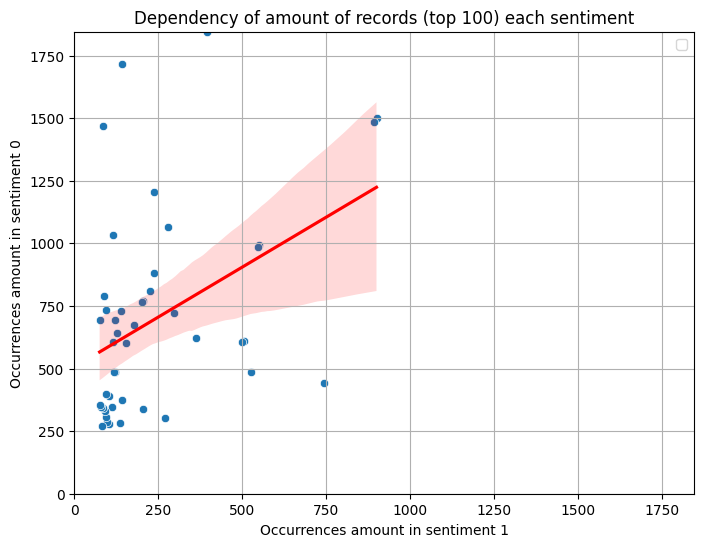

In [59]:
#one of the natural things to do is to check coorelation between sentiment 0 and sentiment 1 among most popular

positivity_100=  pd.DataFrame({'bigrams': postivive_collocations_dict[:100].index.to_list(), 'amount': postivive_collocations_dict[:100]['amount']})
positivity_100.reset_index(drop=True, inplace=True)

negativity_100=  pd.DataFrame({'bigrams': negative_collocations_dict[:100].index.to_list(), 'amount': negative_collocations_dict[:100]['amount']})
negativity_100.reset_index(drop=True, inplace=True)

#consider only bigrams appearing in both groups

positivity_100= positivity_100[positivity_100['bigrams'].isin(negativity_100['bigrams'])]
negativity_100= negativity_100[negativity_100['bigrams'].isin(positivity_100['bigrams'])]

connected_pos_neg = positivity_100.merge(negativity_100, on='bigrams', suffixes=('_df1', '_df2'), how='outer')

plt.figure(figsize=(8, 6))
sns.scatterplot(x='amount_df1', y='amount_df2', data=connected_pos_neg)

# Współczynnik korelacji Spearmana
spearman_corr, _ = stats.spearmanr(connected_pos_neg['amount_df1'], connected_pos_neg['amount_df2'])

# Linia najlepszego dopasowania
sns.regplot(x='amount_df1', y='amount_df2', data=connected_pos_neg, scatter=False, color='r', line_kws={'label':"Linia najlepszego dopasowania (Spearman's r = {:.2f})".format(spearman_corr)})

# Ustawienia osi
x_max = connected_pos_neg['amount_df1'].max()
y_max = connected_pos_neg['amount_df2'].max()
max_val = max(x_max, y_max)
plt.xlim(0, max_val)
plt.ylim(0, max_val)

# Tytuł i etykiety osi
plt.title('Dependency of amount of records (top 100) each sentiment')
plt.xlabel('Occurrences amount in sentiment 1')
plt.ylabel('Occurrences amount in sentiment 0')
plt.grid(True)
plt.legend()
plt.show()

the easy conclussion is that it is not worth considering Spearmann correlation as the data do not fit well to the best fit curve

In [56]:
positivity_full=  pd.DataFrame({'bigrams': postivive_collocations_dict.index.to_list(), 'amount': postivive_collocations_dict['amount']})
positivity_full.reset_index(drop=True, inplace=True)

negativity_full=  pd.DataFrame({'bigrams': negative_collocations_dict.index.to_list(), 'amount': negative_collocations_dict['amount']})
negativity_full.reset_index(drop=True, inplace=True)

c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

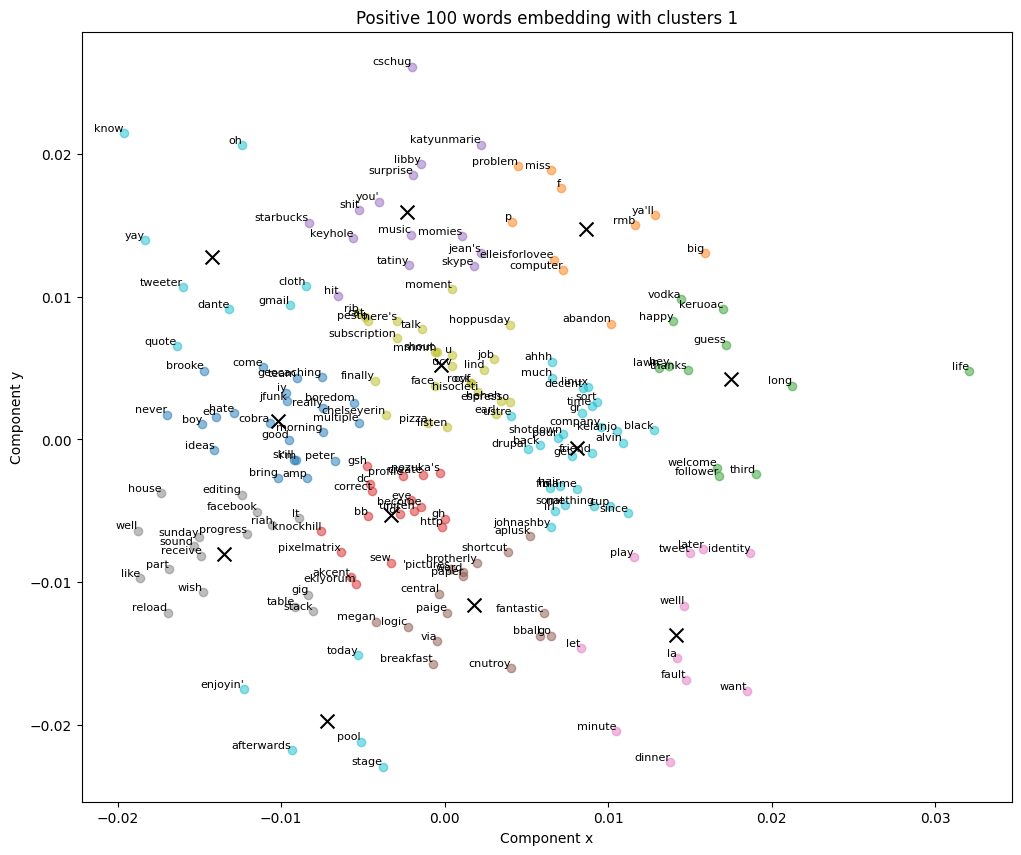

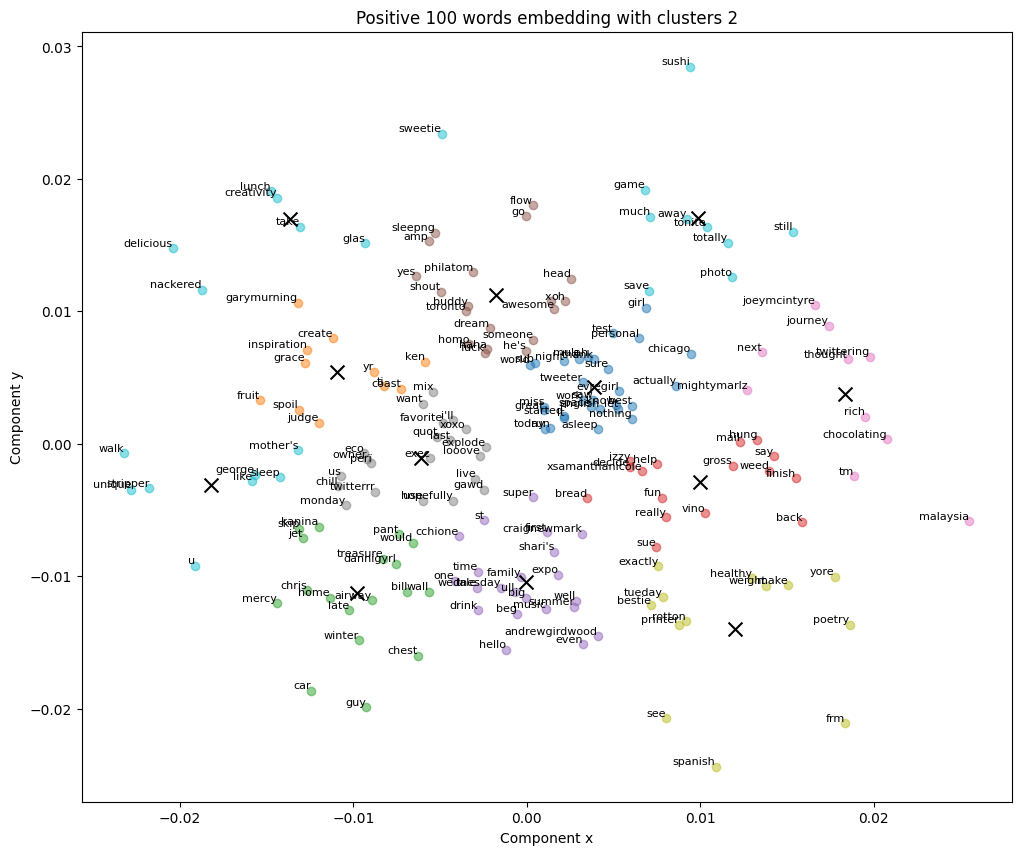

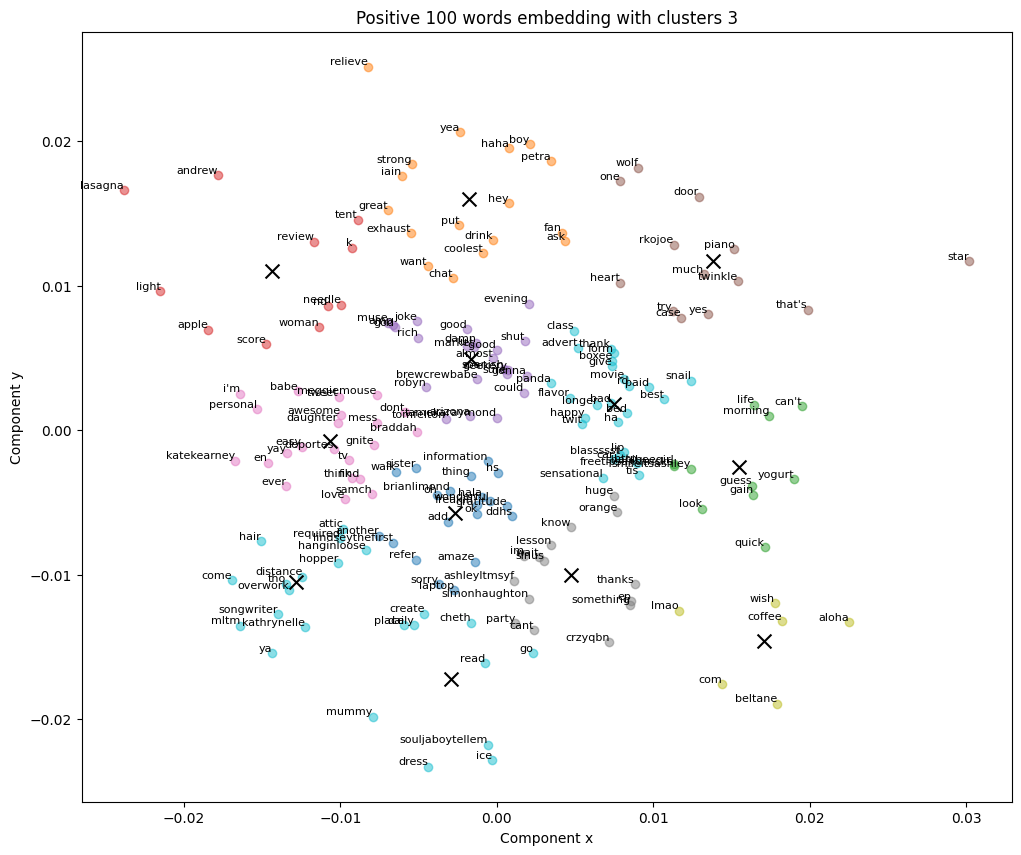

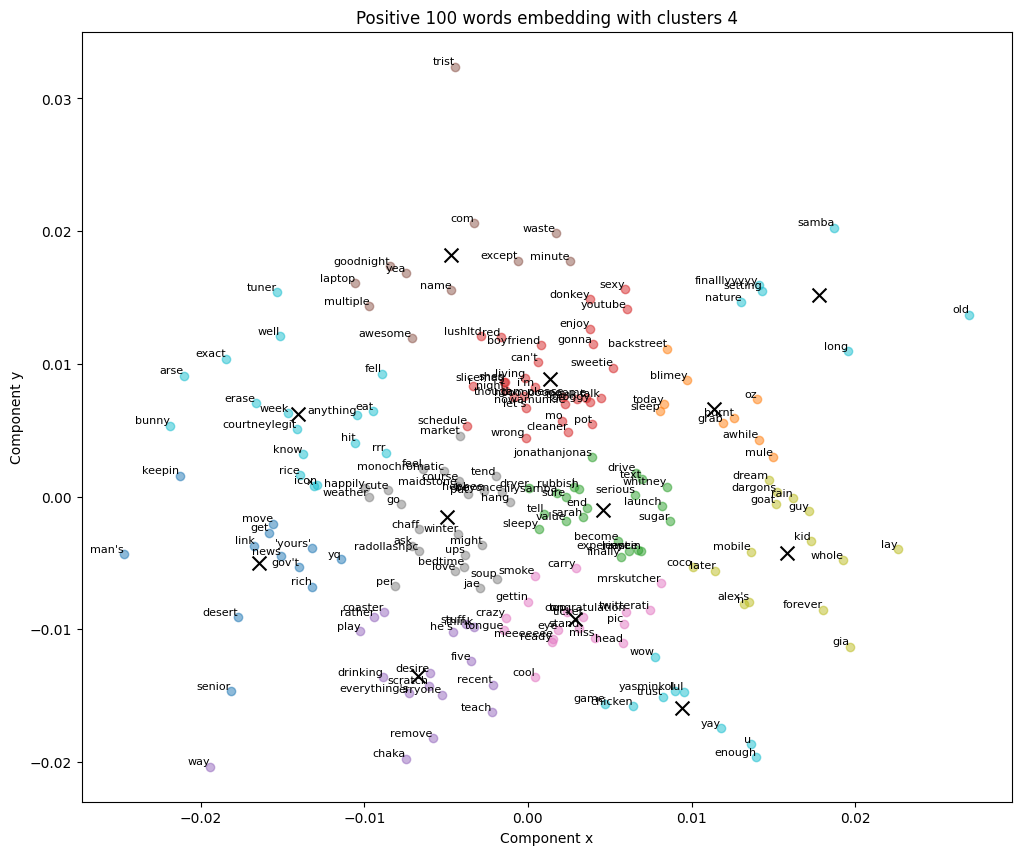

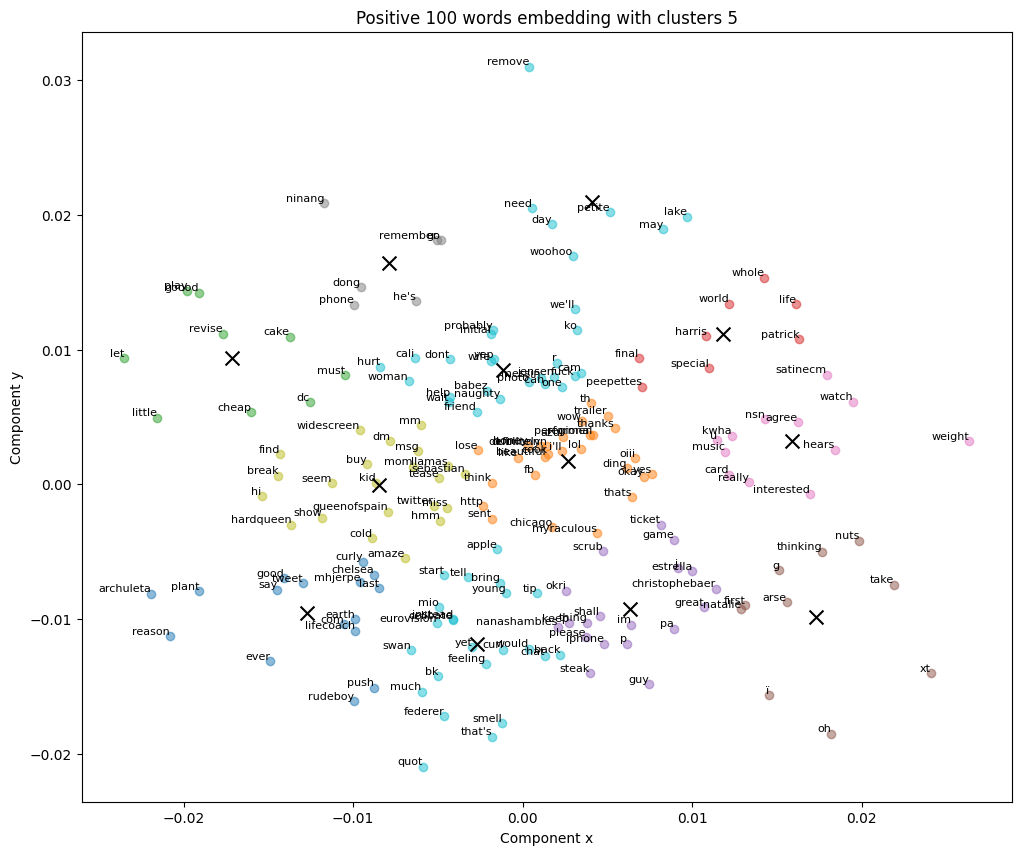

In [61]:
#words embedding

#how is words embedding different then graph representation and what other insights can it give us
#graph representation tells us about connections but due to "not keeping distance" it is rather hard to group those bigrams
#so we used graph to see something compared to distribution or domination of some records.
#in this embedding we rather focus on how the distance affects the thematic grouping of bigrams
#however we have to be careful, this is not equivalent to topic modelling


from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

samples = [random.choices(positivity_full['bigrams'], k=100) for _ in range(5)]

model = Word2Vec(samples[0], vector_size=100, window=5, min_count=1, sg=0)
model1= Word2Vec(samples[1], vector_size=100, window=5, min_count=1, sg=0)
model2= Word2Vec(samples[2], vector_size=100, window=5, min_count=1, sg=0)
model3= Word2Vec(samples[3], vector_size=100, window=5, min_count=1, sg=0)
model4= Word2Vec(samples[4], vector_size=100, window=5, min_count=1, sg=0)

# dimenstion reduction with PCA
def reduce_dimensions(word_vectors):
    pca = PCA(n_components=2)
    pca.fit(word_vectors)
    return pca.transform(word_vectors)

word_vectors = model.wv[model.wv.key_to_index]
word_vectors1= model1.wv[model1.wv.key_to_index]
word_vectors2= model2.wv[model2.wv.key_to_index]
word_vectors3= model3.wv[model3.wv.key_to_index]
word_vectors4= model4.wv[model4.wv.key_to_index]

reduced_word_vectors = reduce_dimensions(word_vectors)
reduced_word_vectors_1 = reduce_dimensions(word_vectors1)
reduced_word_vectors_2 = reduce_dimensions(word_vectors2)
reduced_word_vectors_3 = reduce_dimensions(word_vectors3)
reduced_word_vectors_4 = reduce_dimensions(word_vectors4)

def cluster_embeddings(word_vectors, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(word_vectors)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    return labels, centroids

num_clusters = 12

labels, centroids = cluster_embeddings(reduced_word_vectors, num_clusters)
labels1, centroids1= cluster_embeddings(reduced_word_vectors_1, num_clusters)
labels2, centroids2= cluster_embeddings(reduced_word_vectors_2, num_clusters)
labels3, centroids3= cluster_embeddings(reduced_word_vectors_3, num_clusters)
labels4, centroids4= cluster_embeddings(reduced_word_vectors_4, num_clusters)

def plot_embeddings_with_clusters(word_vectors, words, labels, centroids, which):
    plt.figure(figsize=(12, 10))
    for i in range(len(labels)):
        plt.scatter(word_vectors[i, 0], word_vectors[i, 1], color=plt.cm.tab10(labels[i]), alpha=0.5)
        plt.text(word_vectors[i, 0], word_vectors[i, 1], words[i], fontsize=8, ha='right', va='bottom')
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', color='black', s=100)
    plt.xlabel('Component x')
    plt.ylabel('Component y')
    plt.title('Positive 100 words embedding with clusters '+ str(which))
    plt.show()

plot_embeddings_with_clusters(reduced_word_vectors, model.wv.index_to_key, labels, centroids, 1)
plot_embeddings_with_clusters(reduced_word_vectors_1, model1.wv.index_to_key, labels1, centroids1, 2)
plot_embeddings_with_clusters(reduced_word_vectors_2, model2.wv.index_to_key, labels2, centroids2, 3)
plot_embeddings_with_clusters(reduced_word_vectors_3, model3.wv.index_to_key, labels3, centroids3, 4)
plot_embeddings_with_clusters(reduced_word_vectors_4, model4.wv.index_to_key, labels4, centroids4, 5)

c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

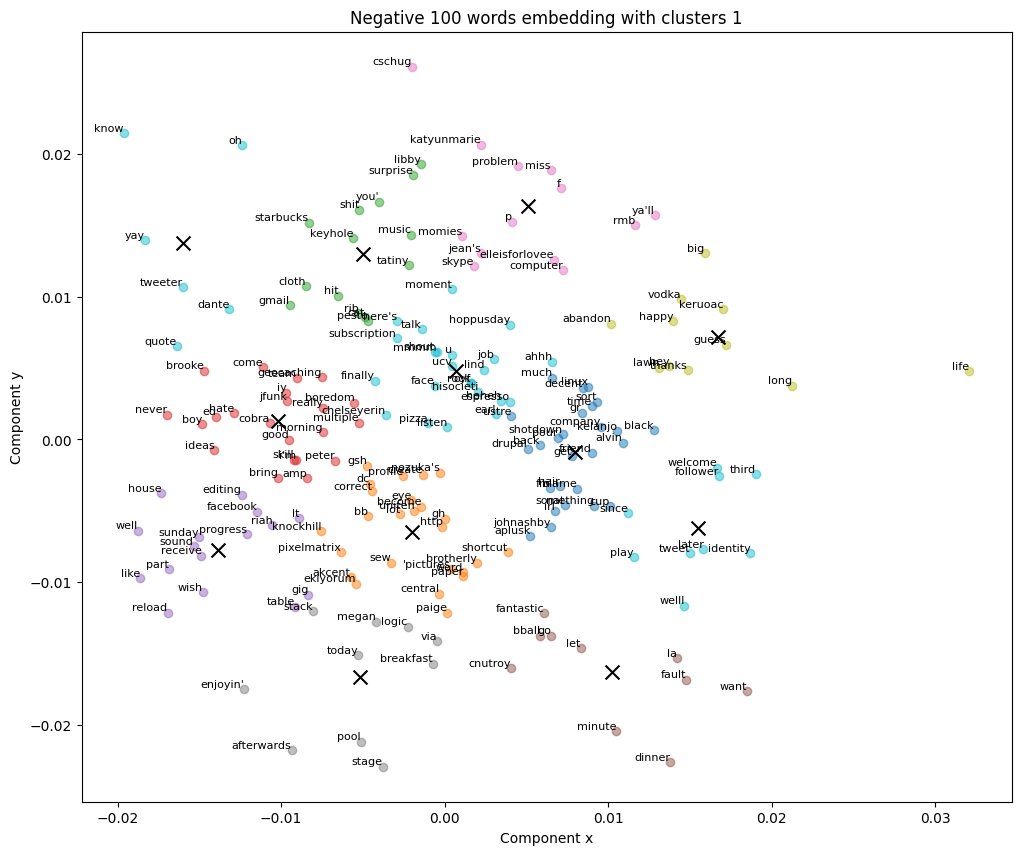

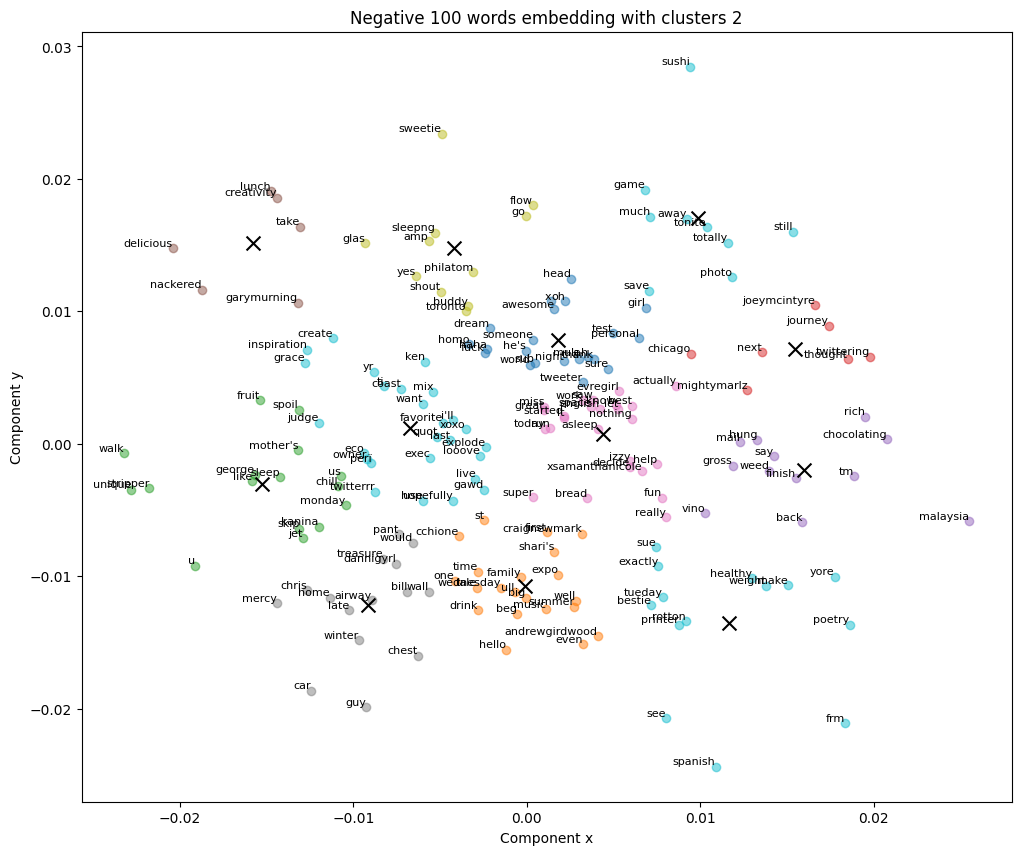

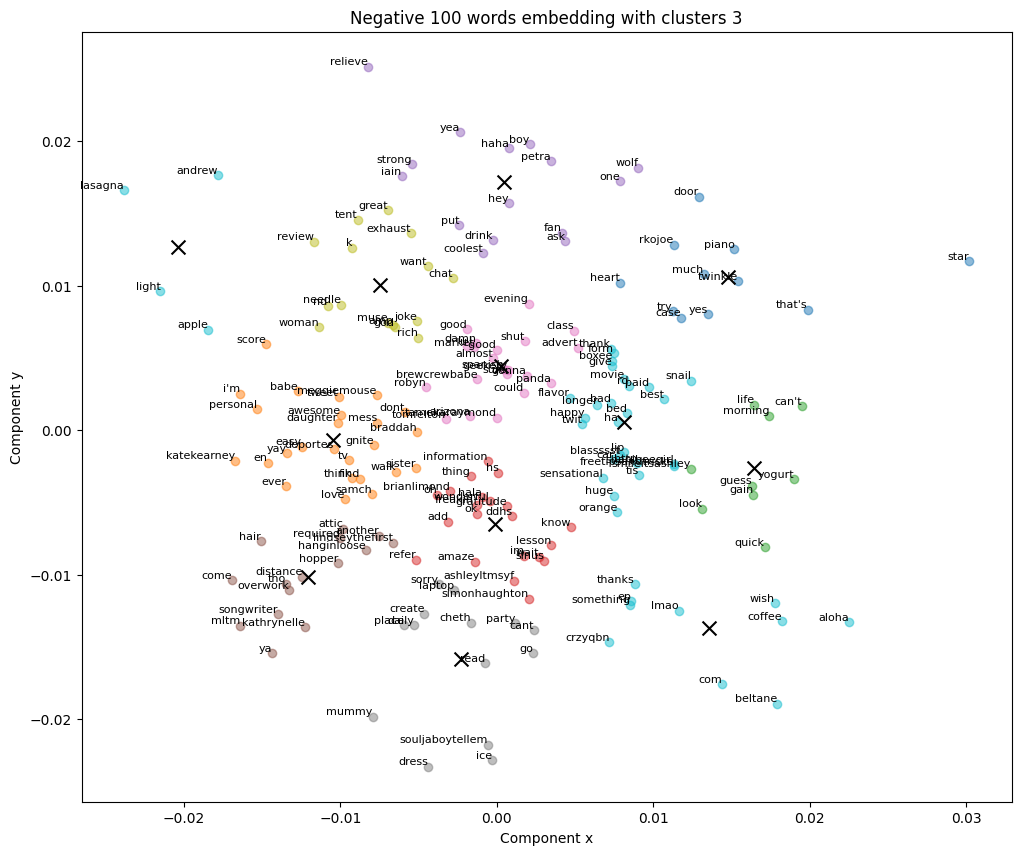

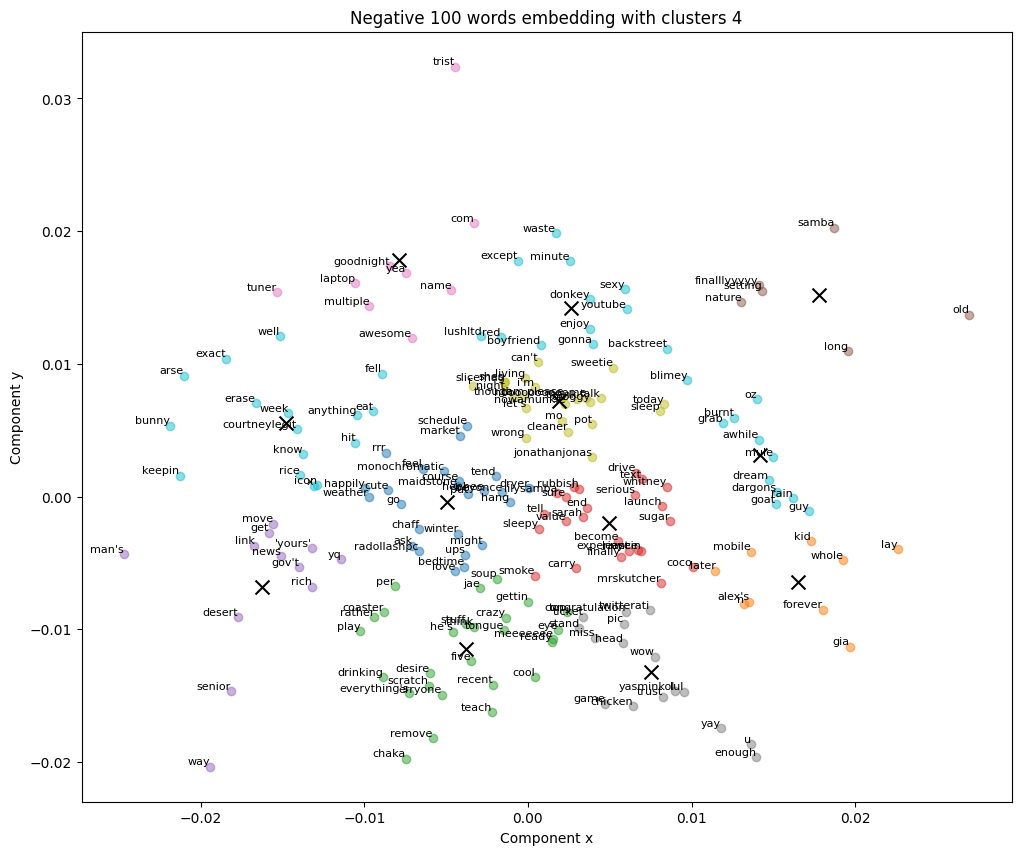

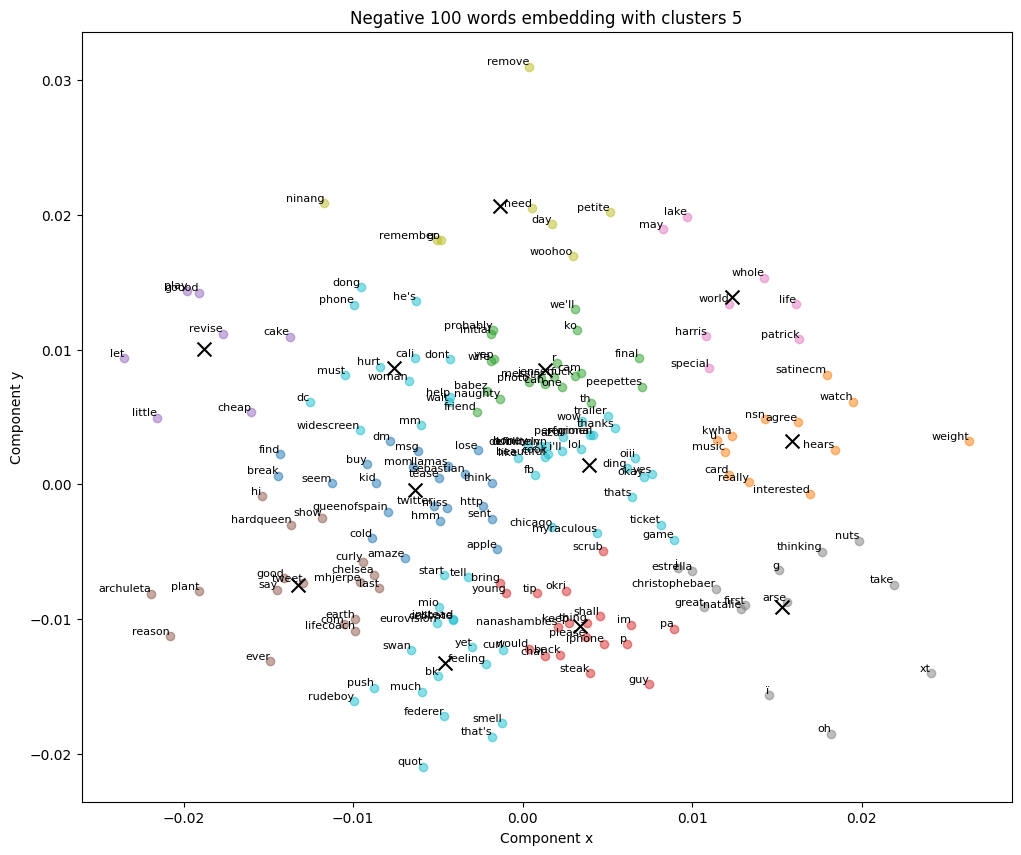

In [62]:
#the same goes for negatives, a code redundation is a problem here

negative_samples = [random.choices(negativity_full['bigrams'], k=100) for _ in range(5)]

models_list= [Word2Vec(samples[i], vector_size=100, window=5, min_count=1, sg=0) for i in range(5)]

# dimenstion reduction with PCA
def reduce_dimensions(word_vectors):
    pca = PCA(n_components=2)
    pca.fit(word_vectors)
    return pca.transform(word_vectors)


reduces_word_vectors_list= [0, 0, 0, 0, 0]

for i in range(5):
    reduces_word_vectors_list[i]= reduce_dimensions(models_list[i].wv[models_list[i].wv.key_to_index])

def cluster_embeddings(word_vectors, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(word_vectors)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    return labels, centroids

num_clusters = 12

labels= []
centroids= []

for i in range(5):
    l, c= cluster_embeddings(reduces_word_vectors_list[i], num_clusters)
    labels.append(l)
    centroids.append(c)

def plot_embeddings_with_clusters(word_vectors, words, labels, centroids, which):
    plt.figure(figsize=(12, 10))
    for i in range(len(labels)):
        plt.scatter(word_vectors[i, 0], word_vectors[i, 1], color=plt.cm.tab10(labels[i]), alpha=0.5)
        plt.text(word_vectors[i, 0], word_vectors[i, 1], words[i], fontsize=8, ha='right', va='bottom')
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', color='black', s=100)
    plt.xlabel('Component x')
    plt.ylabel('Component y')
    plt.title('Negative 100 words embedding with clusters '+ str(which))
    plt.show()

for i in range(5):
    plot_embeddings_with_clusters(reduces_word_vectors_list[i], models_list[i].wv.index_to_key, labels[i], centroids[i], i+1)

### Topics and their statiments analysis

here we model over 35 topics and check whether there are some common things about words belonging to each topic<br>
that is the reason why we model 35 topics, first to set them, then to check in below cell for what amount of topics the coherence_score is the biggest<br>
after that we visualize this topics on some sort of interactive board using **pyLDAvis**

In [108]:
positive_tweets = tweets_df[tweets_df['Target'] == 1]

#Checking the number of positive tweets
num_positive_tweets = positive_tweets.shape[0]

# Select a sample of 50,000 positive tweets or all if the number is less
if num_positive_tweets >= 50000:
    sampled_positive_tweets = positive_tweets.sample(n=50000, random_state=1)  # Ustaw random_state dla powtarzalności
else:
    sampled_positive_tweets = positive_tweets

# Prepare words from positive tweets
words_positive = sampled_positive_tweets['lemmatized_tokens'].tolist()

# Creating a dictionary and corpus for LDA
dictionary = corpora.Dictionary(words_positive)
corpus = [dictionary.doc2bow(text) for text in words_positive]

# Setting the number of topics
num_topics = 35

# Creating a LDA model
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=30, minimum_probability=0.01)

# Calculating thematic coherence
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_positive, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score (LDA): {coherence_lda}')

# Wyświetlanie tematów
for i, topic in enumerate(lda_model.print_topics()):
    print(f'Topic: {i+1} \nWords: {topic[1]}\n')

Coherence Score (LDA): 0.370258985902237
Topic: 1 
Words: 0.175*"see" + 0.098*"wait" + 0.078*"can't" + 0.065*"guy" + 0.032*"buy" + 0.029*"saw" + 0.027*"sun" + 0.019*"anything" + 0.018*"kinda" + 0.017*"super"

Topic: 2 
Words: 0.294*"day" + 0.122*"happy" + 0.056*"today" + 0.038*"great" + 0.037*"birthday" + 0.030*"mom" + 0.029*"mother" + 0.023*"mother's" + 0.018*"far" + 0.013*"hope"

Topic: 3 
Words: 0.218*"u" + 0.096*"yes" + 0.050*"n" + 0.043*"r" + 0.041*"may" + 0.035*"ask" + 0.019*"catch" + 0.019*"crazy" + 0.015*"chat" + 0.013*"pay"

Topic: 4 
Words: 0.170*"well" + 0.074*"hope" + 0.051*"soon" + 0.037*"read" + 0.036*"excite" + 0.036*"pic" + 0.031*"get" + 0.029*"party" + 0.028*"later" + 0.026*"cute"

Topic: 5 
Words: 0.077*"always" + 0.066*"could" + 0.055*"wish" + 0.052*"b" + 0.041*"send" + 0.036*"around" + 0.036*"yesterday" + 0.027*"till" + 0.026*"st" + 0.024*"believe"

Topic: 6 
Words: 0.151*"twitter" + 0.065*"enjoy" + 0.054*"glad" + 0.031*"hello" + 0.028*"wonderful" + 0.027*"family" +

In [41]:
#quick analysis as we may see the coherence score is not too big for given topics amount(the words do not fit very well to each other), that's the reason
#we will try to use maximize the coherence value by trying different num_topics(find the maximum of one value)

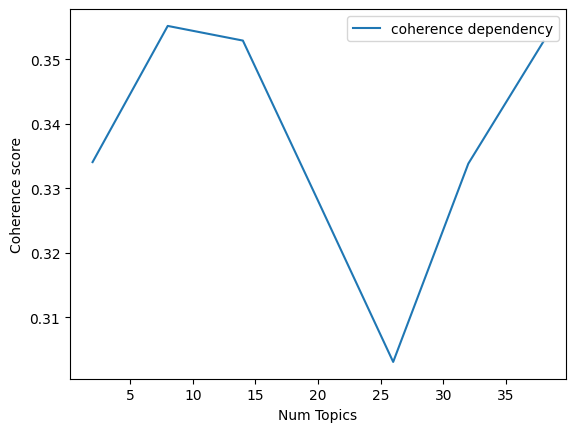

In [68]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
   
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):

        model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=30, minimum_probability=0.01)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=words_positive, start=2, limit=40, step=6)

x = range(2, 40, 6)

coherence_frame= pd.DataFrame({"Num Topics": range(2, 40, 6), "Coherence score": coherence_values})

sns.lineplot(data= coherence_frame, x="Num Topics", y="Coherence score")
plt.legend(labels= ['coherence dependency'])
plt.show()

as we see mayby for 35 topics the value isn't the biggest(more topics could mean higher coherence score) but from the range [0, 35] it is worth the most to consider 35 topics not less not more

In [69]:
# #now it is time to visualize topic modelling some effects(setting 35 topics for more readibly)
# #we will use one of the best tools for that, below we have interactive board, where we can check whether is is specific "thing" for topic

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='tsne', R=100)
vis

C:\Users\igorr\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -3.063615 -2.628879       1        1  4.928734
15    -3.000221 -2.278016       2        1  4.780836
33    -2.858535 -2.729521       3        1  4.479652
20    -1.816528 -3.516693       4        1  4.299736
14    -2.152833 -3.305731       5        1  4.052710
34    -2.631345 -3.186747       6        1  3.665189
23    -1.878929 -1.457919       7        1  3.581343
16    -2.908972 -2.346455       8        1  3.489735
18    -2.713311 -2.597161       9        1  3.306221
1     -1.547469 -2.992548      10        1  3.193878
30    -2.805555 -2.319715      11        1  3.109784
22    -2.553739 -2.729635      12        1  3.090046
12    -1.678131 -3.192138      13        1  2.879196
0     -1.272227 -2.001300      14        1  2.807311
19    -2.590888 -2.403987      15        1  2.789619
9     -1.449084 -2.682235      16        1  2.753691
25    -1.827814 -2.853655      17        1  2.684259
11    -2.159666 -2.664509      18        1  2.625281
7     -2.059580 -2.760941      19        1  2.425265
21    -2.300809 -2.494812      20        1  2.409845
13    -2.319612 -2.517714      21        1  2.402286
17    -1.626027 -2.522748      22        1  2.391961
29    -2.182741 -2.111648      23        1  2.362869
10    -2.247713 -1.759758      24        1  2.333194
6     -1.858670 -2.266073      25        1  2.306363
31    -1.440993 -2.435967      26        1  2.268816
8     -1.873313 -1.921467      27        1  2.265176
28    -1.608273 -2.125045      28        1  2.240803
24    -2.368693 -2.314800      29        1  2.221930
2     -1.740169 -2.140752      30        1  2.172232
26    -1.982393 -2.377975      31        1  2.153970
27    -1.864875 -2.327549      32        1  2.113070
32    -1.695873 -2.337808      33        1  1.875618
4     -1.749270 -2.322075      34        1  1.779757
3     -1.756739 -2.225381      35        1  1.759619, topic_info=        Term         Freq        Total Category   logprob   loglift
67       day  4533.000000  4533.000000  Default  100.0000  100.0000
268     love  3822.000000  3822.000000  Default   99.0000   99.0000
76      good  4824.000000  4824.000000  Default   98.0000   98.0000
277     quot  3272.000000  3272.000000  Default   97.0000   97.0000
3       http  3457.000000  3457.000000  Default   96.0000   96.0000
82       com  2616.000000  2616.000000  Default   95.0000   95.0000
172   thanks  2602.000000  2602.000000  Default   94.0000   94.0000
43     today  2223.000000  2223.000000  Default   93.0000   93.0000
20      like  3054.000000  3054.000000  Default   92.0000   92.0000
28      well  2281.000000  2281.000000  Default   91.0000   91.0000
..       ...          ...          ...      ...       ...       ...
2      diego     0.032147    23.471880  Topic35  -12.2919   -2.5532
3       http     0.032147  3457.853823  Topic35  -12.2919   -7.5458
4    instead     0.032147   125.821718  Topic35  -12.2919   -4.2322
5       june     0.032147    97.130048  Topic35  -12.2919   -3.9734
6         ly     0.032147   590.236048  Topic35  -12.2919   -5.7779
7     master     0.032147    25.292120  Topic35  -12.2919   -2.6278
8    meeting     0.032147   113.339689  Topic35  -12.2919   -4.1277
9        san     0.032147    51.071743  Topic35  -12.2919   -3.3306
11    sweden     0.032147    16.241515  Topic35  -12.2919   -2.1849
12        th     0.032147   353.311837  Topic35  -12.2919   -5.2647

[4174 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
158      30  0.990452       '
1560     18  0.869719  'cause
3556     18  0.983258     'em
2293      7  0.988044      's
3358      3  0.918060    'the
4085      7  0.822429   'time
696       7  0.901543     aah
4819     11  0.900941   aaron
2390     18  0.936604      ab
1008     20  0.989961    able
...     ...       ...     ...
2781     20  0.990264     yum
5276     34  0.930885    yumm
3479     33 

### Adding columns with positivity/negativity/neutral etc

In [70]:
# one may need to install !pip install afinn

# Initialization
afinn = Afinn()
sia = SentimentIntensityAnalyzer()

def calculate_sentiments(text):
    # Using TextBlob
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    # Using VADER
    vader_scores = sia.polarity_scores(text)

    # Using AFINN
    afinn_score = afinn.score(text)

    return {
        'polarity': polarity,
        'subjectivity': subjectivity,
        'negative': vader_scores['neg'],
        'neutral': vader_scores['neu'],
        'positive': vader_scores['pos'],
        'compound': vader_scores['compound'],
        'afinn_score': afinn_score,
    }

# Applying the function to each row in the DataFrame
tweets_df['sentiments'] = tweets_df['Text'].apply(calculate_sentiments)
dev_val_df['sentiments'] = dev_val_df['Text'].apply(calculate_sentiments)
team_validation['sentiments'] = team_validation['Text'].apply(calculate_sentiments)

tweets_df = pd.concat([tweets_df.drop(['sentiments'], axis=1), tweets_df['sentiments'].apply(pd.Series)], axis=1)
dev_val_df= pd.concat([dev_val_df.drop(['sentiments'], axis=1), dev_val_df['sentiments'].apply(pd.Series)], axis=1)
team_validation = pd.concat([team_validation.drop(['sentiments'], axis=1), team_validation['sentiments'].apply(pd.Series)], axis=1)

In [71]:
#checking how are data frame looks after changes
tweets_df.head()

,Target,Date,Text,tokens,tags,lemmatized_tokens,words_counted,collocations,polarity,subjectivity,negative,neutral,positive,compound,afinn_score
2316,0,Tue Apr 07 01:08:23 PDT 2009,A day negotiating wth insurers after spilling ...,"[day, negotiating, wth, insurers, spilling, be...","[(day, NN), (negotiating, VBG), (wth, NN), (in...","[day, negotiate, wth, insurer, spill, beer, la...",11,"[(day, negotiate), (negotiate, wth), (wth, ins...",0.000000,0.066667,0.272,0.728,0.000,-0.6808,-1.0
29697,0,Sun Apr 19 23:17:52 PDT 2009,mindyyeung whats wrong,"[mindyyeung, whats, wrong]","[(mindyyeung, NN), (whats, NNS), (wrong, VBP)]","[mindyyeung, whats, wrong]",3,"[(mindyyeung, whats), (whats, wrong)]",-0.500000,0.900000,0.608,0.392,0.000,-0.4767,-2.0
797003,0,Thu Jun 25 09:02:20 PDT 2009,hey you twitterers out there which mac virus ...,"[hey, twitterers, mac, virus, protection, soft...","[(hey, NN), (twitterers, NNS), (mac, VBP), (vi...","[hey, twitterer, mac, virus, protection, softw...",14,"[(hey, twitterer), (twitterer, mac), (mac, vir...",0.566667,0.633333,0.000,0.671,0.329,0.8834,7.0
409607,0,Sat Jun 06 17:25:30 PDT 2009,I'm stressed about this A'level,"[i'm, stressed, a'level]","[(i'm, NN), (stressed, VBD), (a'level, NN)]","[i'm, stress, a'level]",3,"[(i'm, stress), (stress, a'level)]",0.000000,0.000000,0.375,0.625,0.000,-0.3400,-2.0
175753,0,Fri May 29 15:07:14 PDT 2009,damn sunburn hurting jack whitehall mmmmm,"[damn, sunburn, hurting, jack, whitehall, mmmmm]","[(damn, NN), (sunburn, NN), (hurting, VBG), (j...","[damn, sunburn, hurt, jack, whitehall, mmmmm]",6,"[(damn, sunburn), (sunburn, hurt), (hurt, jack...",0.000000,0.000000,0.574,0.426,0.000,-0.6597,-4.0


### Adding columns with information whether the 'text' is complex and if it contains negation

In [72]:
#one may have to install this
#!pip install spacy
#!python -m spacy download en_core_web_sm

nlp = spacy.load('en_core_web_sm')

# function to text analysis
def analyze_text(text):
    # text analysis using Spacy
    doc = nlp(text)
    
    # sentences analysis
    sentences = list(doc.sents)
    is_complex = len(sentences) > 1  # True, jeśli mamy więcej niż jedno zdanie
    
    # looking for negations
    has_negation = any(token.dep_ == 'neg' for token in doc)
    
    return {'complex': is_complex, 'negation': has_negation}

tweets_df[['complex', 'negation']] = tweets_df['Text'].apply(lambda text: pd.Series(analyze_text(text)))
tweets_df['complex'] = tweets_df['complex'].astype(int)
tweets_df['negation'] = tweets_df['negation'].astype(int)

dev_val_df[['complex', 'negation']] = dev_val_df['Text'].apply(lambda text: pd.Series(analyze_text(text)))
dev_val_df['complex'] = dev_val_df['complex'].astype(int)
dev_val_df['negation'] = dev_val_df['negation'].astype(int)

team_validation[['complex', 'negation']] = team_validation['Text'].apply(lambda text: pd.Series(analyze_text(text)))
team_validation['complex'] = team_validation['complex'].astype(int)
team_validation['negation'] = team_validation['negation'].astype(int)

tweets_df[['Text', 'complex', 'negation']].head()

,Text,complex,negation
2316,A day negotiating wth insurers after spilling ...,0,0
29697,mindyyeung whats wrong,0,0
797003,hey you twitterers out there which mac virus ...,0,0
409607,I'm stressed about this A'level,0,0
175753,damn sunburn hurting jack whitehall mmmmm,0,0


In [76]:
team_validation.head()

,Target,Date,Text,tokens,tags,lemmatized_tokens,words_counted,collocations,polarity,subjectivity,negative,neutral,positive,compound,afinn_score,complex,negation
919197,1,Sun May 10 03:23:02 PDT 2009,Is eating BBQ Jalapeno Torta Subway from Los C...,"[eating, bbq, jalapeno, torta, subway, los, ch...","[(eating, VBG), (bbq, NN), (jalapeno, NN), (to...","[eat, bbq, jalapeno, torta, subway, los, chapa...",10,"[(eat, bbq), (bbq, jalapeno), (jalapeno, torta...",0.142857,0.267857,0.000,1.000,0.000,0.0000,0.0,0,0
962701,1,Sun May 17 10:35:25 PDT 2009,shopping,[shopping],"[(shopping, NN)]",[shopping],1,[],0.000000,0.000000,0.000,1.000,0.000,0.0000,0.0,0,0
674909,0,Fri Jun 19 19:50:36 PDT 2009,Movies with my boys Missed these kids Hate b...,"[movies, boys, missed, kids, hate, away, long,...","[(movies, NNS), (boys, NNS), (missed, VBD), (k...","[movie, boy, miss, kid, hate, away, long, can'...",10,"[(movie, boy), (boy, miss), (miss, kid), (kid,...",-0.425000,0.650000,0.269,0.731,0.000,-0.7096,-5.0,0,1
644244,0,Fri Jun 19 02:33:06 PDT 2009,i want to get out of this place ill be h...,"[want, get, place, ill, happy, whwn, finaly, g...","[(want, JJ), (get, NN), (place, NN), (ill, NN)...","[want, get, place, ill, happy, whwn, finaly, g...",9,"[(want, get), (get, place), (place, ill), (ill...",0.150000,1.000000,0.118,0.672,0.210,0.2960,2.0,0,0
703124,0,Sat Jun 20 11:31:17 PDT 2009,i want to rip this sewn on bandage off my face...,"[want, rip, sewn, bandage, face, week, super, ...","[(want, JJ), (rip, NN), (sewn, NN), (bandage, ...","[want, rip, sewn, bandage, face, week, super, ...",11,"[(want, rip), (rip, sewn), (sewn, bandage), (b...",-0.388889,0.744444,0.267,0.598,0.135,-0.7262,-3.0,0,0


### Adding columns with month, day and hour 

In [78]:
#changing to the proper date time
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'])
dev_val_df['Date'] = pd.to_datetime(dev_val_df['Date'])
team_validation['Date'] = pd.to_datetime(team_validation['Date'])

# Extract hour, day of the week, and month from the 'Date' column
tweets_df['Hour'] = tweets_df['Date'].dt.hour
tweets_df['DayOfWeek'] = tweets_df['Date'].dt.dayofweek
tweets_df['Month'] = tweets_df['Date'].dt.month


dev_val_df['Hour'] = dev_val_df['Date'].dt.hour
dev_val_df['DayOfWeek'] = dev_val_df['Date'].dt.dayofweek
dev_val_df['Month'] = dev_val_df['Date'].dt.month


team_validation['Hour'] = team_validation['Date'].dt.hour
team_validation['DayOfWeek'] = team_validation['Date'].dt.dayofweek
team_validation['Month'] = team_validation['Date'].dt.month


# Create binary columns for each day of the week (0 - Monday, 6 - Sunday)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, day in enumerate(days):
    tweets_df[day] = (tweets_df['DayOfWeek'] == i).astype(int)
    dev_val_df[day] = (dev_val_df['DayOfWeek'] == i).astype(int)
    team_validation[day] = (team_validation['DayOfWeek'] == i).astype(int)

# Define time of day categories
tweets_df['Night'] = (tweets_df['Hour'] <= 7).astype(int)
tweets_df['WorkHours'] = ((tweets_df['Hour'] >=8) & (tweets_df['Hour'] <= 18)).astype(int)
tweets_df['Evening'] = ((tweets_df['Hour'] >= 19) & (tweets_df['Hour'] <= 23)).astype(int)


dev_val_df['Night'] = (dev_val_df['Hour'] <= 7).astype(int)
dev_val_df['WorkHours'] = ((dev_val_df['Hour'] >=8) & (dev_val_df['Hour'] <= 18)).astype(int)
dev_val_df['Evening'] = ((dev_val_df['Hour'] >= 19) & (dev_val_df['Hour'] <= 23)).astype(int)


team_validation['Night'] = (team_validation['Hour'] <= 7).astype(int)
team_validation['WorkHours'] = ((team_validation['Hour'] >=8) & (team_validation['Hour'] <= 18)).astype(int)
team_validation['Evening'] = ((team_validation['Hour'] >= 19) & (team_validation['Hour'] <= 23)).astype(int)

C:\Users\igorr\AppData\Roaming\Python\Python38\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
C:\Users\igorr\AppData\Roaming\Python\Python38\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
C:\Users\igorr\AppData\Roaming\Python\Python38\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise a

### Graphs connected with time and heatmap

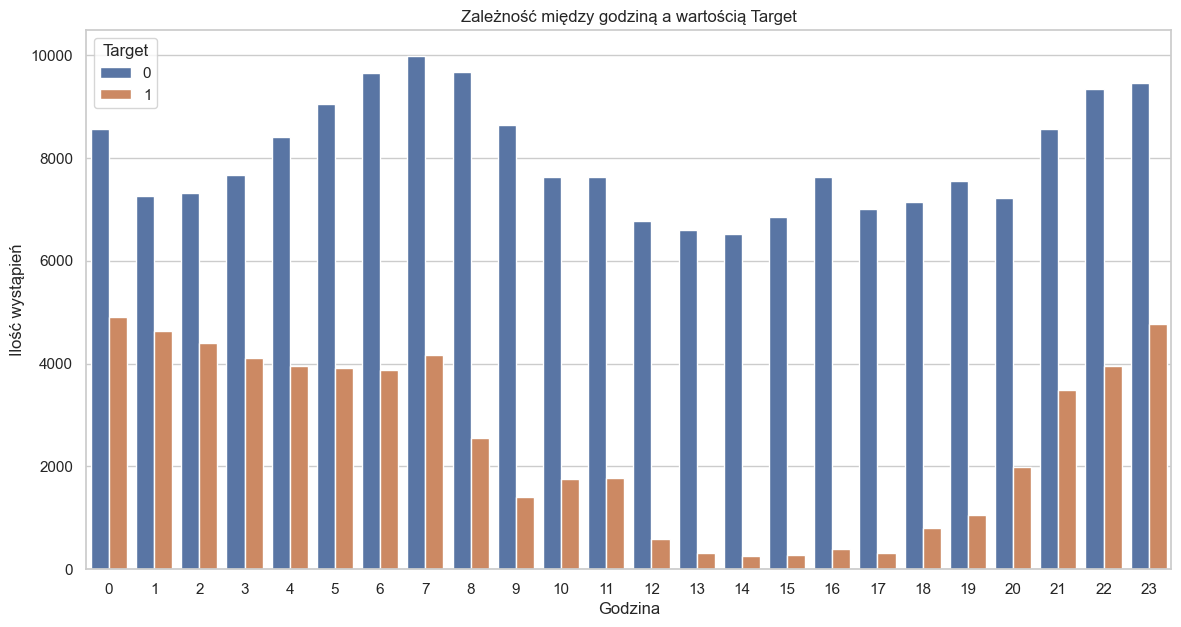

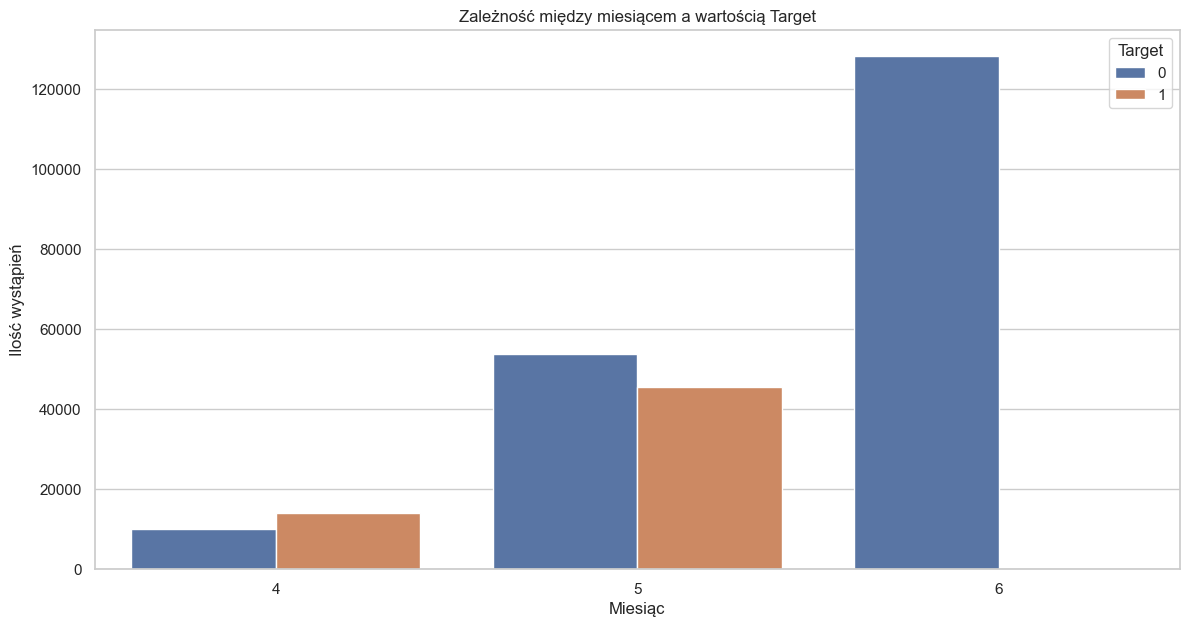

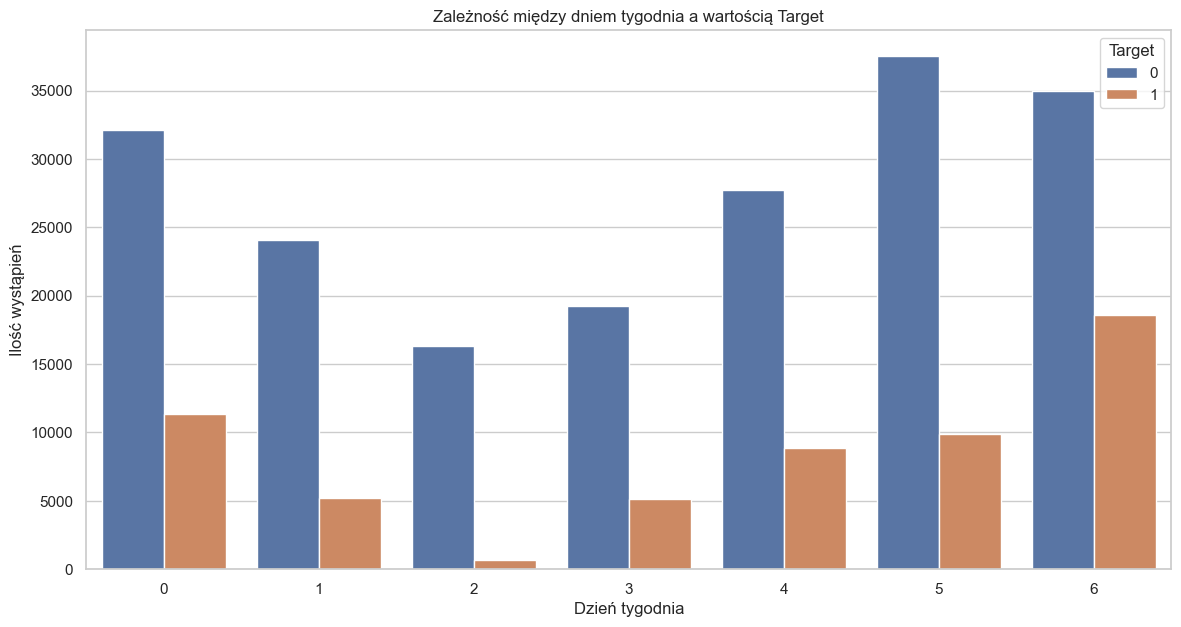

In [79]:
sns.set(style="whitegrid")

# Graph 'Hour' and 'Target'
plt.figure(figsize=(14, 7))
sns.countplot(x='Hour', hue='Target', data=tweets_df)
plt.title('Zależność między godziną a wartością Target')
plt.xlabel('Godzina')
plt.ylabel('Ilość wystąpień')
plt.show()

# Graph 'Month' and 'Target'
plt.figure(figsize=(14, 7))
sns.countplot(x='Month', hue='Target', data=tweets_df)
plt.title('Zależność między miesiącem a wartością Target')
plt.xlabel('Miesiąc')
plt.ylabel('Ilość wystąpień')
plt.show()

# Graph 'DayOfWeek' and 'Target'
plt.figure(figsize=(14, 7))
sns.countplot(x='DayOfWeek', hue='Target', data=tweets_df)
plt.title('Zależność między dniem tygodnia a wartością Target')
plt.xlabel('Dzień tygodnia')
plt.ylabel('Ilość wystąpień')
plt.show()

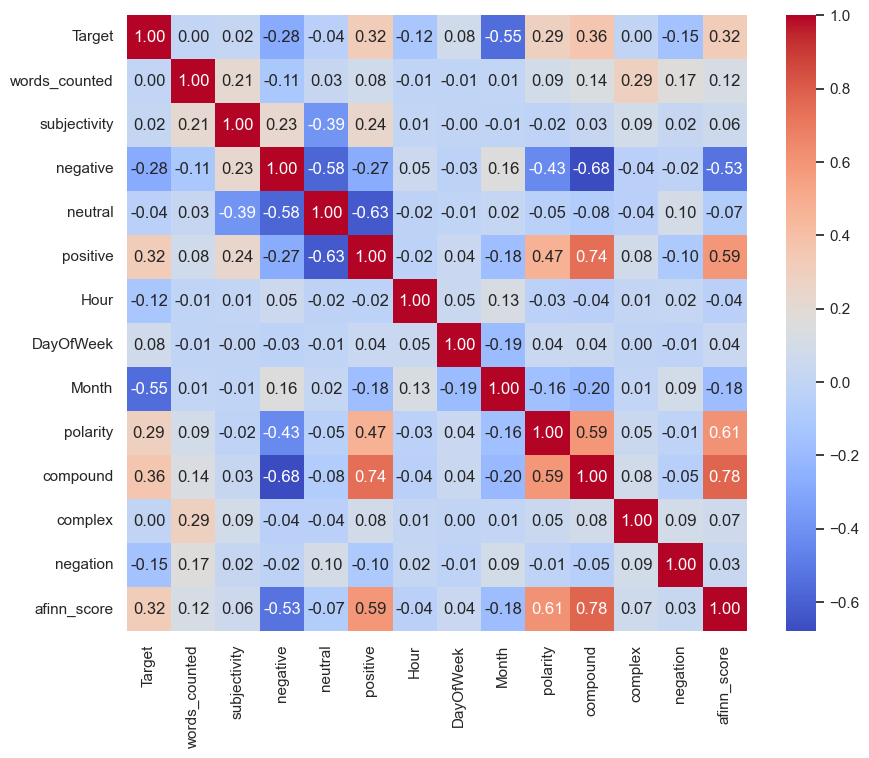

In [80]:
# Assuming tweets_df is your dataframe
correlation_matrix = tweets_df[['Target', 'words_counted', 'subjectivity', 
                                'negative', 'neutral', 'positive', 
                                'Hour', 'DayOfWeek', 'Month','polarity','compound','complex','negation','afinn_score']].corr()

# Using seaborn to create a heatmap with the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# Emotion analysis

In [81]:
# one may need to install: !pip install nrclex

# Define the function to extract emotions
def extract_emotions_nrc(text):
    # Create an NRCLex object
    emotion_analysis = NRCLex(text)

    # Define the 8 basic emotions we're interested in
    emotions = ['fear', 'anger', 'anticipation', 'trust', 'surprise', 'sadness', 'joy', 'disgust']

    # Extract the frequencies of these emotions from the text
    emotion_frequencies = {emotion: emotion_analysis.affect_frequencies.get(emotion, 0) for emotion in emotions}

    # Convert the dictionary to a pandas Series and return it
    return pd.Series(emotion_frequencies)

emotions = ['fear', 'anger', 'anticipation', 'trust', 'surprise', 'sadness', 'joy', 'disgust']

# Assuming 'tweets_df' has a column named 'Text' containing the text to analyze
# Apply the 'extract_emotions_nrc' function to each row in the 'Text' column and add the results as new columns
tweets_df[emotions] = tweets_df['Text'].apply(extract_emotions_nrc)
dev_val_df[emotions] = dev_val_df['Text'].apply(extract_emotions_nrc)
team_validation[emotions] = team_validation['Text'].apply(extract_emotions_nrc)

# Print the DataFrame with the new emotion columns
tweets_df.head(10)

,Target,Date,Text,tokens,tags,lemmatized_tokens,words_counted,collocations,polarity,subjectivity,negative,neutral,positive,compound,afinn_score,complex,negation,Hour,DayOfWeek,Month,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Night,WorkHours,Evening,fear,anger,anticipation,trust,surprise,sadness,joy,disgust
2316,0,2009-04-07 01:08:23,A day negotiating wth insurers after spilling ...,"[day, negotiating, wth, insurers, spilling, be...","[(day, NN), (negotiating, VBG), (wth, NN), (in...","[day, negotiate, wth, insurer, spill, beer, la...",11,"[(day, negotiate), (negotiate, wth), (wth, ins...",0.000000,0.066667,0.272,0.728,0.000,-0.6808,-1.0,0,0,1,1,4,0,1,0,0,0,0,0,1,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000
29697,0,2009-04-19 23:17:52,mindyyeung whats wrong,"[mindyyeung, whats, wrong]","[(mindyyeung, NN), (whats, NNS), (wrong, VBP)]","[mindyyeung, whats, wrong]",3,"[(mindyyeung, whats), (whats, wrong)]",-0.500000,0.900000,0.608,0.392,0.000,-0.4767,-2.0,0,0,23,6,4,0,0,0,0,0,0,1,0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
797003,0,2009-06-25 09:02:20,hey you twitterers out there which mac virus ...,"[hey, twitterers, mac, virus, protection, soft...","[(hey, NN), (twitterers, NNS), (mac, VBP), (vi...","[hey, twitterer, mac, virus, protection, softw...",14,"[(hey, twitterer), (twitterer, mac), (mac, vir...",0.566667,0.633333,0.000,0.671,0.329,0.8834,7.0,0,0,9,3,6,0,0,0,1,0,0,0,0,1,0,0.000000,0.000000,0.100000,0.200000,0.100000,0.000000,0.200000,0.000000
409607,0,2009-06-06 17:25:30,I'm stressed about this A'level,"[i'm, stressed, a'level]","[(i'm, NN), (stressed, VBD), (a'level, NN)]","[i'm, stress, a'level]",3,"[(i'm, stress), (stress, a'level)]",0.000000,0.000000,0.375,0.625,0.000,-0.3400,-2.0,0,0,17,5,6,0,0,0,0,0,1,0,0,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
175753,0,2009-05-29 15:07:14,damn sunburn hurting jack whitehall mmmmm,"[damn, sunburn, hurting, jack, whitehall, mmmmm]","[(damn, NN), (sunburn, NN), (hurting, VBG), (j...","[damn, sunburn, hurt, jack, whitehall, mmmmm]",6,"[(damn, sunburn), (sunburn, hurt), (hurt, jack...",0.000000,0.000000,0.574,0.426,0.000,-0.6597,-4.0,0,0,15,4,5,0,0,0,0,1,0,0,0,1,0,0.142857,0.285714,0.000000,0.000000,0.000000,0.142857,0.000000,0.142857
10277,0,2009-04-18 07:25:55,is tireed,[tireed],"[(tireed, NN)]",[tireed],1,[],0.000000,0.000000,0.000,1.000,0.000,0.0000,0.0,0,0,7,5,4,0,0,0,0,0,1,0,1,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
983079,1,2009-05-18 02:15:10,Simple Minds ï Don't You Forget About Me ...,"[simple, minds, ï, forget, bender, w, fist, en...","[(simple, JJ), (minds, NNS), (ï, VBP), (forget...","[simple, mind, ï, forget, bender, w, fist, end...",16,"[(simple, mind), (mind, ï), (ï, forget), (forg...",0.142857,0.446429,0.000,0.852,0.148,0.4881,1.0,0,1,2,0,5,1,0,0,0,0,0,0,1,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
656400,0,2009-06-19 09:44:35,amberausten i thought i fell off ur map,"[amberausten, thought, fell, ur, map]","[(amberausten, RB), (thought, VBN), (fell, VBD...","[amberausten, think, fell, ur, map]",5,"[(amberausten, think), (think, fell), (fell, u...",0.000000,0.000000,0.000,1.000,0.000,0.0000,0.0,0,0,9,4,6,0,0,0,0,1,0,0,0,1,0,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000
676131,0,2009-06-19 20:24:59,Layn down finally been runnin runnin runnin ...,"[layn, finally, runnin, runnin, runnin, day, h...","[(layn, NN), (finally, RB), (runnin, JJ), (run...","[layn, finally, runnin, runnin, runnin, day, h...",8,"[(layn, finally), (finally, runnin), (runnin, ...",-0.077778,0.644444,0.000,1.000,0.000,0.0000,0.0,0,0,20,4,6,0,0,0,0,1,0,0,0,0,1,0.000000,0.000000,0.166667,0.166667,0.166667,0.000000,0.166667,0.166667
464537,0,2009-06-15 00:12:43,praguematic Yanno I don't think I've ever he...,"[praguematic, yanno, think, i've, ever, heard,...","[(praguematic, JJ), (yanno, NN), (think

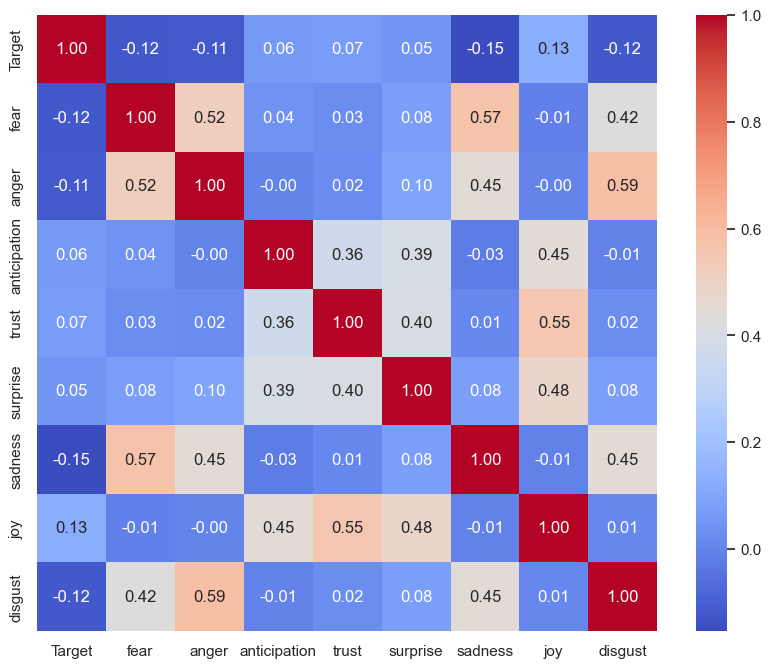

In [82]:
# Assuming tweets_df is your dataframe
correlation_matrix = tweets_df[['Target', 'fear', 'anger' , 'anticipation' , 'trust' , 'surprise' , 'sadness' , 'joy' , 'disgust']].corr(method='spearman')

# Using seaborn to create a heatmap with the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# Linguistic feature analysis

In [83]:
# Function to count exclamation marks in a text
def count_exclamation_marks(text):
    return text.count('!')

# Function to count question marks in a text
def count_question_marks(text):
    return text.count('?')

# Function to count words written in uppercase
def count_uppercase_words(text):
    return sum(word.isupper() for word in text.split())

# Function to count parts of speech
def count_parts_of_speech(tags_list):
    # Counts occurrences of each part-of-speech tag
    tag_counts = Counter(tag for _, tag in tags_list)
    return tag_counts

# Adding new columns to DataFrame
tweets_df['exclamation_count'] = tweets['Text'].apply(count_exclamation_marks)
tweets_df['question_count'] = tweets['Text'].apply(count_question_marks)
tweets_df['uppercase_count'] = tweets['Text'].apply(count_uppercase_words)

dev_val_df['exclamation_count'] = dev_val_df['Text'].apply(count_exclamation_marks)
dev_val_df['question_count'] = dev_val_df['Text'].apply(count_question_marks)
dev_val_df['uppercase_count'] = dev_val_df['Text'].apply(count_uppercase_words)

team_validation['exclamation_count'] = team_validation['Text'].apply(count_exclamation_marks)
team_validation['question_count'] = team_validation['Text'].apply(count_question_marks)
team_validation['uppercase_count'] = team_validation['Text'].apply(count_uppercase_words)

# If the 'tags' column contains strings formatted as tuples, we first process them
# Otherwise, we assume they are already tuples and use them directly
if isinstance(tweets_df['tags'].iloc[0], str):
    import ast
    tweets_df['tags'] = tweets_df['tags'].apply(ast.literal_eval)

if isinstance(dev_val_df['tags'].iloc[0], str):
    import ast
    dev_val_df['tags'] = dev_val_df['tags'].apply(ast.literal_eval)

if isinstance(team_validation['tags'].iloc[0], str):
    import ast
    team_validation['tags'] = team_validation['tags'].apply(ast.literal_eval)

# Creating a dictionary with the frequency of each part of speech for each entry
tweets_df['pos_counts'] = tweets_df['tags'].apply(count_parts_of_speech)
dev_val_df['pos_counts'] = dev_val_df['tags'].apply(count_parts_of_speech)
team_validation['pos_counts'] = team_validation['tags'].apply(count_parts_of_speech)


# Creating separate columns for each part of speech
pos_tags = set(tag for sublist in tweets_df['tags'].tolist() for _, tag in sublist)
pos_tags1 = set(tag for sublist in dev_val_df['tags'].tolist() for _, tag in sublist)
pos_tags2 = set(tag for sublist in team_validation['tags'].tolist() for _, tag in sublist)

for tag in pos_tags:
    tweets_df[f'count_{tag}'] = tweets_df['pos_counts'].apply(lambda x: x.get(tag, 0))

for tag in pos_tags1:
    dev_val_df[f'count_{tag}'] = dev_val_df['pos_counts'].apply(lambda x: x.get(tag, 0))

for tag in pos_tags2:
    team_validation[f'count_{tag}'] = team_validation['pos_counts'].apply(lambda x: x.get(tag, 0))

# Now tweets_df contains new columns with the requested information
tweets_df.head()  # Display the first few rows for confirmation

,Target,Date,Text,tokens,tags,lemmatized_tokens,words_counted,collocations,polarity,subjectivity,negative,neutral,positive,compound,afinn_score,complex,negation,Hour,DayOfWeek,Month,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Night,WorkHours,Evening,fear,anger,anticipation,trust,surprise,sadness,joy,disgust,exclamation_count,question_count,uppercase_count,pos_counts,count_$,count_JJ,count_VBG,count_PRP,count_NNS,count_CD,count_SYM,count_MD,count_VBP,count_'',count_NNPS,count_POS,count_TO,count_WDT,count_WP,count_VBZ,count_NNP,count_JJR,count_DT,count_LS,count_NN,count_RP,count_WRB,count_RBR,count_CC,count_FW,count_PRP$,count_JJS,count_WP$,count_IN,count_PDT,count_EX,count_VBD,count_RBS,count_RB,count_VB,count_UH,count_VBN
2316,0,2009-04-07 01:08:23,A day negotiating wth insurers after spilling ...,"[day, negotiating, wth, insurers, spilling, be...","[(day, NN), (negotiating, VBG), (wth, NN), (in...","[day, negotiate, wth, insurer, spill, beer, la...",11,"[(day, negotiate), (negotiate, wth), (wth, ins...",0.000000,0.066667,0.272,0.728,0.000,-0.6808,-1.0,0,0,1,1,4,0,1,0,0,0,0,0,1,0,0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.5,0.000000,0,0,1,"{'NN': 6, 'VBG': 2, 'NNS': 1, 'JJ': 1, 'RB': 1}",0,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
29697,0,2009-04-19 23:17:52,mindyyeung whats wrong,"[mindyyeung, whats, wrong]","[(mindyyeung, NN), (whats, NNS), (wrong, VBP)]","[mindyyeung, whats, wrong]",3,"[(mindyyeung, whats), (whats, wrong)]",-0.500000,0.900000,0.608,0.392,0.000,-0.4767,-2.0,0,0,23,6,4,0,0,0,0,0,0,1,0,0,1,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,0,0,"{'NN': 1, 'NNS': 1, 'VBP': 1}",0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
797003,0,2009-06-25 09:02:20,hey you twitterers out there which mac virus ...,"[hey, twitterers, mac, virus, protection, soft...","[(hey, NN), (twitterers, NNS), (mac, VBP), (vi...","[hey, twitterer, mac, virus, protection, softw...",14,"[(hey, twitterer), (twitterer, mac), (mac, vir...",0.566667,0.633333,0.000,0.671,0.329,0.8834,7.0,0,0,9,3,6,0,0,0,1,0,0,0,0,1,0,0.000000,0.000000,0.1,0.2,0.1,0.000000,0.2,0.000000,0,1,0,"{'NN': 8, 'NNS': 1, 'VBP': 1, 'MD': 1, 'VB': 1...",0,2,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
409607,0,2009-06-06 17:25:30,I'm stressed about this A'level,"[i'm, stressed, a'level]","[(i'm, NN), (stressed, VBD), (a'level, NN)]","[i'm, stress, a'level]",3,"[(i'm, stress), (stress, a'level)]",0.000000,0.000000,0.375,0.625,0.000,-0.3400,-2.0,0,0,17,5,6,0,0,0,0,0,1,0,0,1,0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,0,0,"{'NN': 2, 'VBD': 1}",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
175753,0,2009-05-29 15:07:14,damn sunburn hurting jack whitehall mmmmm,"[damn, sunburn, hurting, jack, whitehall, mmmmm]","[(damn, NN), (sunburn, NN), (hurting, VBG), (j...","[damn, sunburn, hurt, jack, whitehall, mmmmm]",6,"[(damn, sunburn), (sunburn, hurt), (hurt, jack...",0.000000,0.000000,0.574,0.426,0.000,-0.6597,-4.0,0,0,15,4,5,0,0,0,0,1,0,0,0,1,0,0.142857,0.285714,0.0,0.0,0.0,0.142857,0.0,0.142857,0,0,0,"{'NN': 5, 'VBG': 1}",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


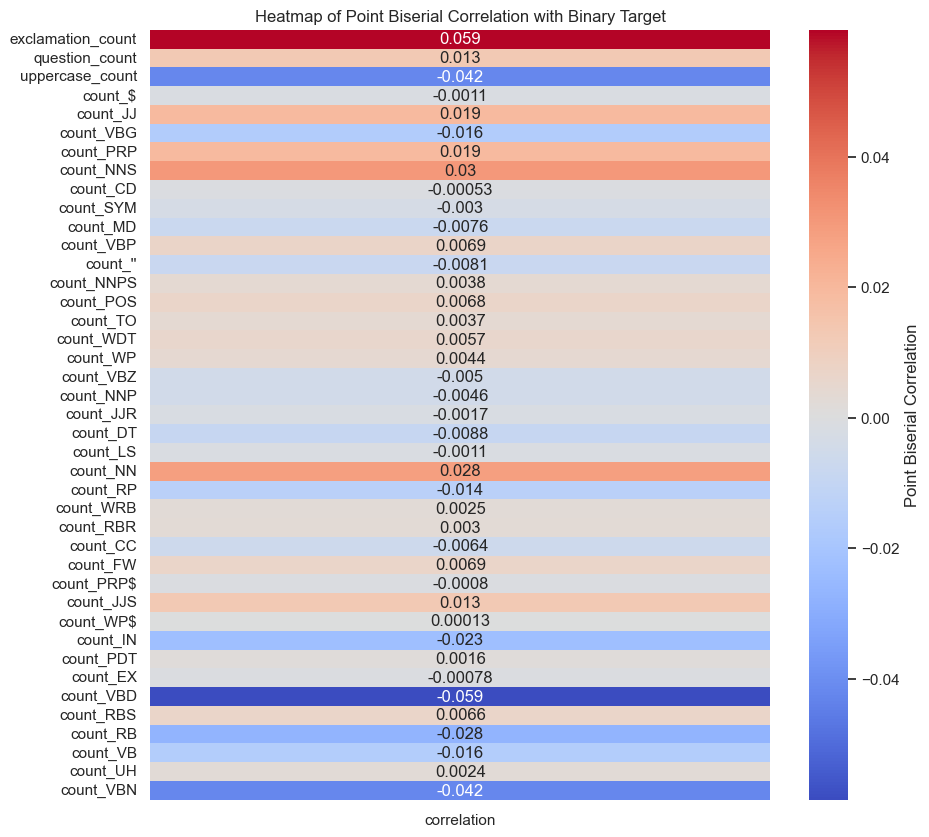

In [84]:
# Function to calculate point-biserial correlation
def calculate_pointbiserial(df, column):
    return pointbiserialr(df[column], df['Target']).correlation

# Creating a DataFrame to store correlation results
correlations = pd.DataFrame(index=['exclamation_count', 'question_count', 'uppercase_count'] + [f'count_{tag}' for tag in pos_tags])

# Calculating point-biserial correlation for each new column
correlations['correlation'] = correlations.index.map(lambda col: calculate_pointbiserial(tweets_df, col))

# Creating a heatmap of correlations
plt.figure(figsize=(10, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', cbar_kws={'label': 'Point Biserial Correlation'})
plt.title('Heatmap of Point Biserial Correlation with Binary Target')
plt.show()

now before the **Feature Engineering** section we will save the results to make it easier to read data in the next milestone<br>
there have been already creating new columns which we will later use in the next step<br>
we can say that few things from feature engineering have already been done in the first step- in the exploratory data analysis

In [85]:
#saving results

# tweets_df.to_csv('tweets_df_after_first_step.csv', index=False)
# dev_val_df.to_csv('dev_val_df_after_first_step.csv', index=False)
# team_validation.to_csv('team_validation_after_first_step.csv', index=False)